# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (**+2 балла**) Добавить Batch normalization.
- (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (**+1 балл**) Также реализовать оптимизатор Adam.

## Импорты

In [ ]:
import torch
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import itertools
import math
import torch.nn as nn
import numpy as np
import torch.optim as optim
import pytorch_lightning as L
import seaborn as sns
import os

from torch import nn
from torchvision.datasets import FashionMNIST
from torch.nn import functional
from torchvision.transforms import ToTensor
from torch.optim.optimizer import Optimizer
from lightning.pytorch.loggers import CSVLogger
from glob import glob
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Optimizer
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from tabulate import tabulate
from IPython.display import display
from pytorch_lightning.loggers import CSVLogger

## Константы

In [17]:
RANDOM_SEED = 777
WORKERS = 12

## Датасет

Для данной задачи был выбран датасет **FashionMNIST**, который является одним из многих, предоставляемых PyTorch

**FashionMNIST** — это популярный датасет с изображениями одежды, который часто используется для обучения и тестирования моделей машинного обучения. 

Вот основные характеристики датасета **FashionMNIST**:

- **Содержимое**: Датасет состоит из 70,000 черно-белых изображений, разделенных на 60,000 обучающих и 10,000 тестовых. Каждое изображение имеет размер 28x28 пикселей.

- **Классы**: FashionMNIST включает 10 различных классов одежды:

    0. T-shirt/top
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt
    7. Sneaker
    8. Bag
    9. Ankle boot

- **Формат данных**: Каждое изображение представлено в виде 2D массива (28x28), где значения пикселей находятся в диапазоне от 0 до 255 (черно-белые изображения).

Разделим и сохраним *testing_set* и *training_set*

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.43MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 547kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.98MB/s]

Training samples: 10000
Validation samples: 12000
Test samples: 10000

Some samples from each set:


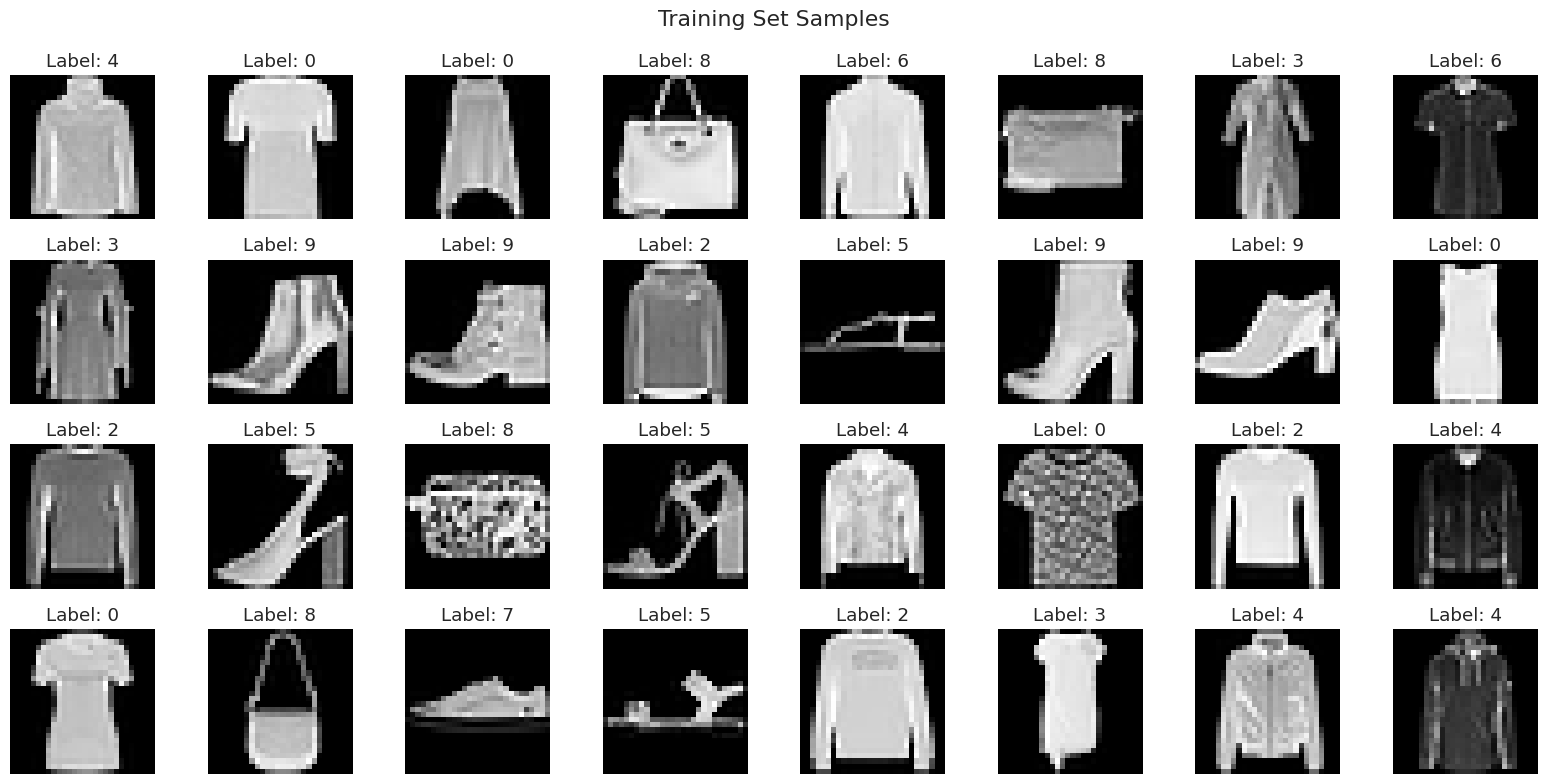

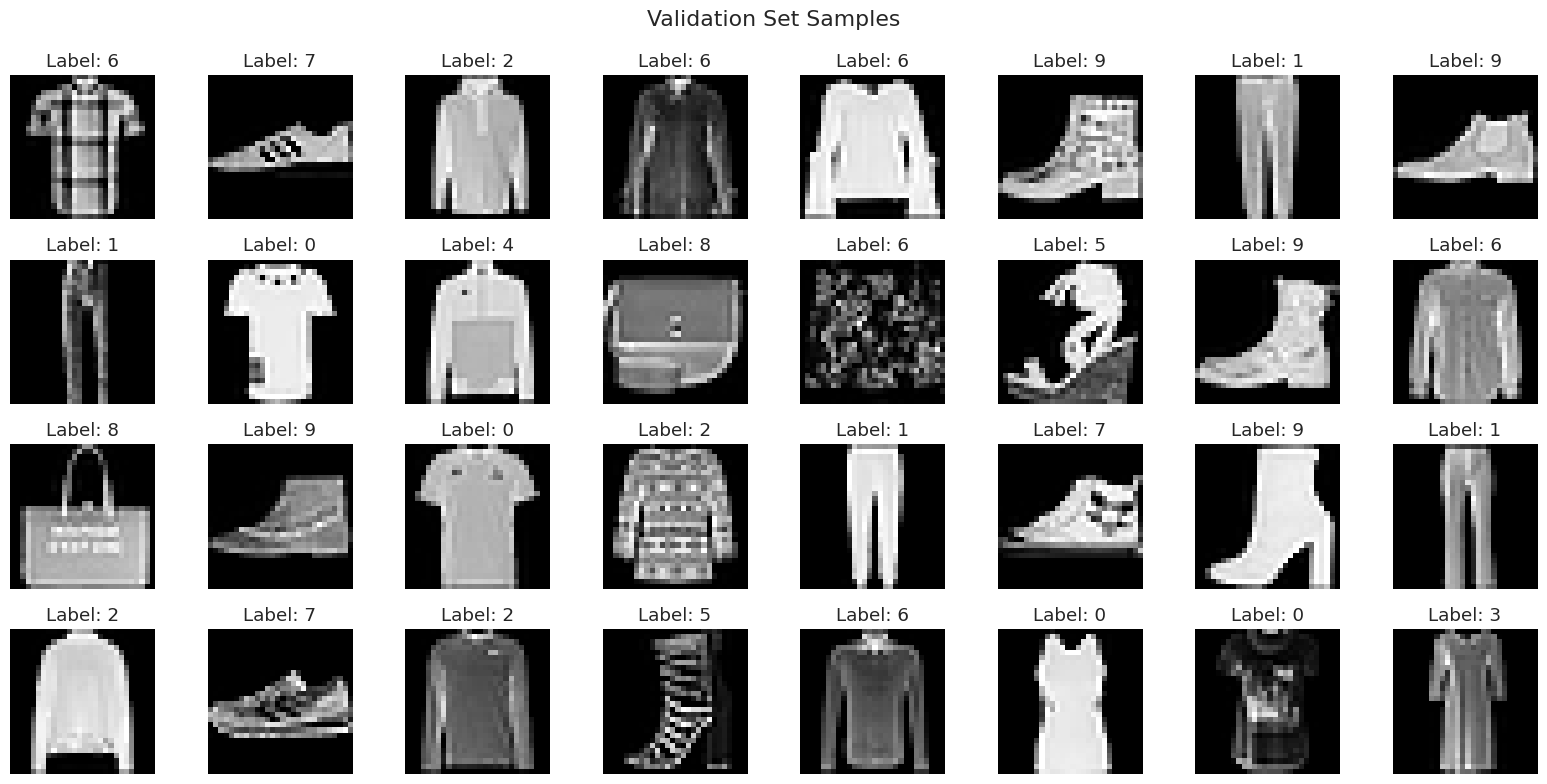

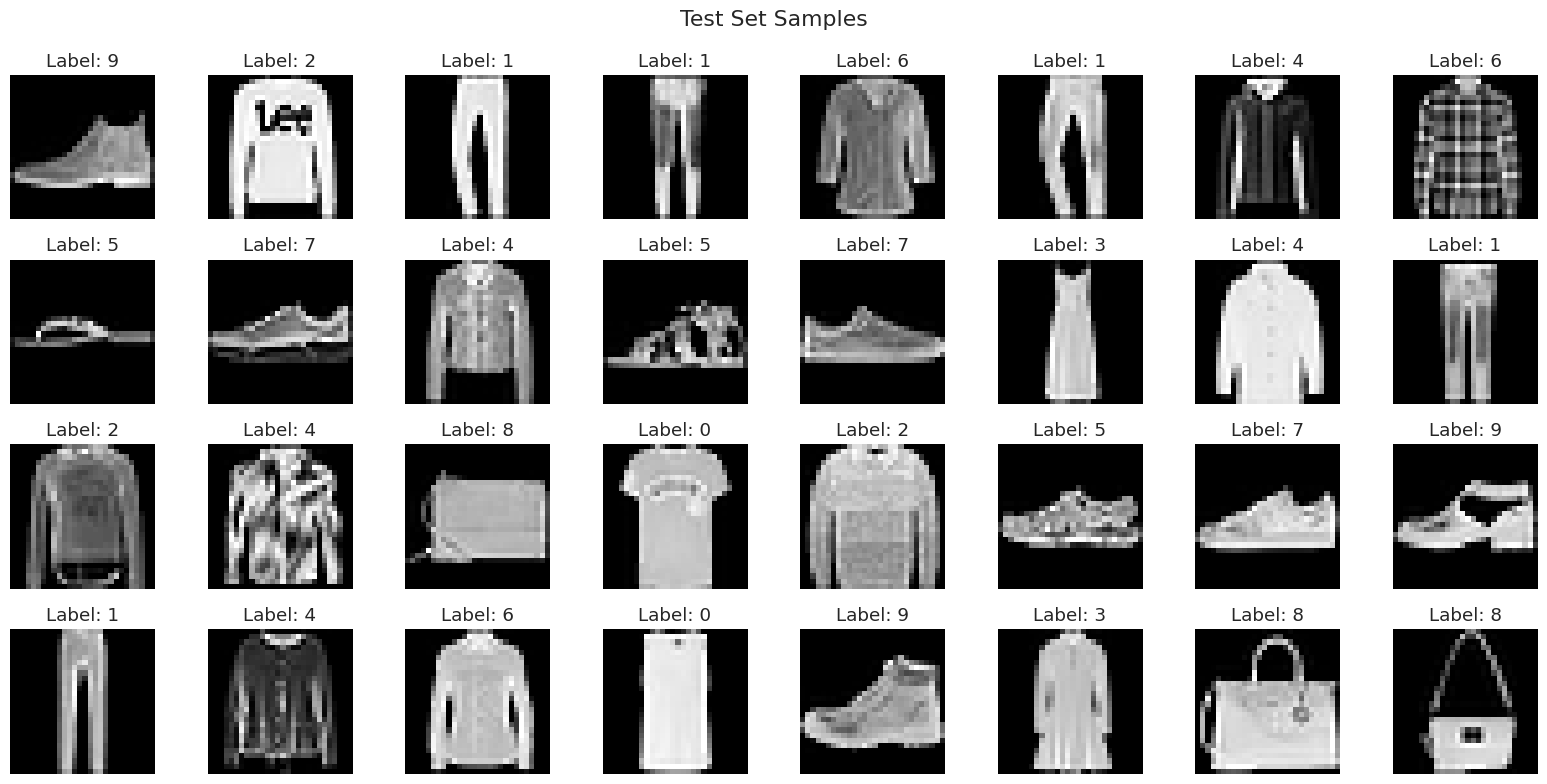

In [18]:
def get_transforms(augment=True):
    transforms = [
        ToTensor(),
        Normalize((0.2860,), (0.3530,))
    ]
    if augment:
        transforms.insert(0, RandomHorizontalFlip(p=0.5))
        transforms.insert(0, RandomRotation(10))
    return Compose(transforms)

full_training_set = FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=get_transforms(augment=True)
)

testing_set = FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=get_transforms(augment=False)
)

train_indices, val_indices = train_test_split(
    range(len(full_training_set)),
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=full_training_set.targets.numpy()
)

training_set = Subset(full_training_set, train_indices)
validation_set = Subset(full_training_set, val_indices)

validation_set.dataset.transform = get_transforms(augment=False)

def create_loader(dataset, batch_size=64, shuffle=False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=WORKERS,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=True
    )

train_loader = create_loader(testing_set, shuffle=True)
validation_loader = create_loader(validation_set)
test_loader = create_loader(testing_set)

print(f"Training samples: {len(testing_set)}")
print(f"Validation samples: {len(validation_set)}")
print(f"Test samples: {len(testing_set)}")
print("\nSome samples from each set:")

def plot_samples(loader, title):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx in range(32):
        img = images[idx].numpy().squeeze()
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Label: {labels[idx].item()}")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_samples(train_loader, "Training Set Samples")
plot_samples(validation_loader, "Validation Set Samples")
plot_samples(test_loader, "Test Set Samples")

## Реализация слоев

Этот код реализует два основных типа слоев для нейронной сети: полносвязный слой и слой активации ReLU, как и требовалось в условии, с возможностью прямого и обратного прохода (forward и backward pass).

In [19]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features, dtype=torch.float):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features, dtype=dtype) * torch.sqrt(torch.tensor(2.0 / in_features, dtype=dtype)))
        self.bias = nn.Parameter(torch.zeros(out_features, dtype=dtype))

    def forward(self, x):
        self.x = x
        return torch.matmul(x, self.weight) + self.bias 

    def init_weights(self):
        nn.init.xavier_normal_(self.weight)
        nn.init.uniform_(self.bias, -0.1, 0.1)

    def backward(self, grad_output):
        x_grad = torch.matmul(grad_output, self.weight.T)
        weight_grad = torch.matmul(grad_output.T, self.x).T
        bias_grad = grad_output.sum(0)
        
        return x_grad, weight_grad, bias_grad


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return functional.relu(x)
    
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.x <= 0] = 0
        return grad_input

## Реализация нейронной сети

In [20]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, hidden_size=256, batch_normalization=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_normalization = batch_normalization
        self.input_layer = FullyConnectedLayer(28 * 28, hidden_size)
        self.relu = ReluLayer() 
        self.output_layer = FullyConnectedLayer(hidden_size, 10)
        self.batch_norm = nn.BatchNorm1d(hidden_size) if batch_normalization else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        if self.batch_normalization:
            x = self.batch_norm(x)
        x = self.output_layer(x)
        return x
    
    def init_weights(self):
        self.input_layer.init_weights()
        self.output_layer.init_weights()

## Реализиция вспомогательной Lightning-модели

LitModel - это класс, реализованный на основе LightningModule из библиотеки PyTorch Lightning, который инкапсулирует логику обучения, валидации и тестирования нейросетевой модели. Модель включает следующие ключевые компоненты:

- Архитектура модели:
Используется пользовательская нейросеть MyNeuralNetwork, которая принимает параметры: hidden_size — размер скрытого слоя,
batch_normalization — флаг, определяющий, применяется ли batch normalization.

- Оптимизатор с L2-регуляризацией:
Оптимизатор (optimizer) принимает параметры модели, learning rate и коэффициент весового затухания (weight_decay), что соответствует L2-регуляризации. Это помогает предотвратить переобучение, штрафуя большие веса модели.

- Функция потерь: В качестве функции потерь используется CrossEntropyLoss, стандартная для задач классификации.

- Проверка градиентов выполняется численная проверка градиентов (_validate_gradients):
Сравниваются аналитически вычисленные градиенты (param.grad) с численно аппроксимированными (через метод конечных разностей).

Если разница между градиентами превышает 1e-3, выводится предупреждение. Это помогает отлавливать ошибки в обратном распространении.

In [ ]:
class LitModel(L.LightningModule):
    def __init__(self, hidden_size, batch_normalization, optimizer, lr, weight_decay):
        super().__init__()
        self.model = MyNeuralNetwork(hidden_size=hidden_size, batch_normalization=batch_normalization)
        self.optimizer = optimizer(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def training_step(self, data_batch, batch_index):
        input_data, target = data_batch
        input_data = input_data.view(input_data.size(0), -1)
        predictions = self.model(input_data)
        error = nn.functional.cross_entropy(predictions, target)
        
        if batch_index % 100 == 0:
            # Проверерка корректности вычисления градиента на каждом шаге
            self._validate_gradients(input_data, target, error)
            
        self.log("train_loss", error.item(), prog_bar=True)
        return error

    def _validate_gradients(self, x, y, loss):
        eps = 1e-4
        for name, param in self.model.named_parameters():
            if param.grad is None:
                continue
                
            analytic_grad = param.grad.data
            numerical_grad = torch.zeros_like(param.data)
            
            it = np.nditer(param.data.detach().numpy(), flags=['multi_index'])
            while not it.finished:
                idx = it.multi_index
                original = param.data[idx].item()
                
                param.data[idx] = original + eps
                loss_plus = nn.functional.cross_entropy(self.model(x), y)
                
                param.data[idx] = original - eps
                loss_minus = nn.functional.cross_entropy(self.model(x), y)
                
                param.data[idx] = original
                numerical_grad[idx] = (loss_plus - loss_minus) / (2 * eps)
                it.iternext()
            
            grad_diff = torch.norm(analytic_grad - numerical_grad) / (
                torch.norm(analytic_grad) + torch.norm(numerical_grad))
            if grad_diff > 1e-3:
                print(f"Large gradient difference in {name}: {grad_diff.item()}")

    def test_step(self, data_batch, batch_index):
        input_data, target = data_batch
        input_data = input_data.view(input_data.size(0), -1)
        predictions = self.model(input_data)
        predicted_labels = torch.argmax(predictions, dim=1)
        accuracy = torch.sum(predicted_labels == target).item() / len(target)
        self.log_dict({"test_acc": accuracy})

    def validation_step(self, data_batch, batch_index):
        input_data, target = data_batch
        input_data = input_data.view(input_data.size(0), -1)
        predictions = self.model(input_data)
        error = nn.functional.cross_entropy(predictions, target)
        predicted_labels = torch.argmax(predictions, dim=1)
        accuracy = torch.sum(predicted_labels == target).item() / len(target)
        self.log_dict({"val_loss": error.item(), "val_acc": accuracy})

    def configure_optimizers(self):
        return self.optimizer

## Реализация оптимизатора Adam

Адам - это популярный алгоритм оптимизации, используемый для обновления weights and biases нейронной сети во время обучения.

In [22]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)
        
        self.state = dict()
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict()
                self.state[p]['step'] = 0
                self.state[p]['m'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                self.state[p]['v'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                if group['amsgrad']:
                    self.state[p]['v_max'] = torch.zeros_like(p, memory_format=torch.preserve_format)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    grads.append(p.grad)
                    state = self.state[p]
                    exp_avgs.append(state['m'])
                    exp_avg_sqs.append(state['v'])
                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['v_max'])
                    state['step'] += 1
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

def adam(params,
         grads,
         exp_avgs,
         exp_avg_sqs,
         max_exp_avg_sqs,
         state_steps,
         amsgrad,
         beta1,
         beta2,
         lr,
         weight_decay,
         eps):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        
        if amsgrad:
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            denom = max_exp_avg_sqs[i].sqrt().add_(eps)
        else:
            denom = exp_avg_sq.sqrt().add_(eps)

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step
        step_size = lr / bias_correction1
        
        param.addcdiv_(exp_avg, denom, value=-step_size * (math.sqrt(bias_correction2) if amsgrad else 1.0))

## Подбор параметров

Перебор гиперпараметров:

Создается класс HyperparameterGrid для генерации всех комбинаций параметров:

- Оптимизаторы: Adagrad (для интереса), Adam (который мы реализовали), RMSprop (один из двух предложенных)

- Learning rate: 0.01 и 0.001

- Размер скрытого слоя: 100 и 1000 нейронов

- Batch Normalization: с и без

Всего 24 комбинации (3 оптимизатора × 2 LR × 2 размера × 2 BN). Посмотрим для начала, какие комбинации будут лучшими на небольшом числе эпох (3), потом обучим на модель на них, и посмотрим, как они себя покажут на бОльшем числе эпох (15)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Total experiments to run: 24

Training with: Adagrad, lr=1e-02, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.08675000071525574
        val_loss            3.2687134742736816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-02, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1616666615009308
        val_loss             2.970715284347534
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-02, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.13375000655651093
        val_loss             3.346721887588501
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-02, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1758333295583725
        val_loss            2.9045181274414062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-03, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.10716667026281357
        val_loss            2.9382271766662598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-03, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1145833358168602
        val_loss             2.97244930267334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-03, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1081666648387909
        val_loss            2.8578076362609863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adagrad, lr=1e-03, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.13591666519641876
        val_loss            3.0628998279571533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-02, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.140666663646698
        val_loss            2.5983474254608154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-02, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.09841666370630264
        val_loss            3.2651891708374023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-02, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.04675000160932541
        val_loss            3.6791164875030518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-02, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.11025000363588333
        val_loss            3.2876439094543457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-03, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc           0.041083332151174545
        val_loss             3.540198802947998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-03, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.05225000157952309
        val_loss            3.0561182498931885
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-03, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.12974999845027924
        val_loss             3.08689284324646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: Adam, lr=1e-03, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1289999932050705
        val_loss            3.1676087379455566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-02, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.09208333492279053
        val_loss            3.5426042079925537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-02, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.10108333081007004
        val_loss             3.133497476577759
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-02, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.15049999952316284
        val_loss            3.4217073917388916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-02, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.07750000059604645
        val_loss            2.7096638679504395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-03, hidden_size=100, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.13099999725818634
        val_loss            3.0152692794799805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-03, hidden_size=100, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.0689999982714653
        val_loss            3.1982812881469727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-03, hidden_size=1000, batch_norm=False
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.15074999630451202
        val_loss             2.798997402191162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training with: RMSprop, lr=1e-03, hidden_size=1000, batch_norm=True
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc           0.050999999046325684
        val_loss             3.101945400238037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=3` reached.


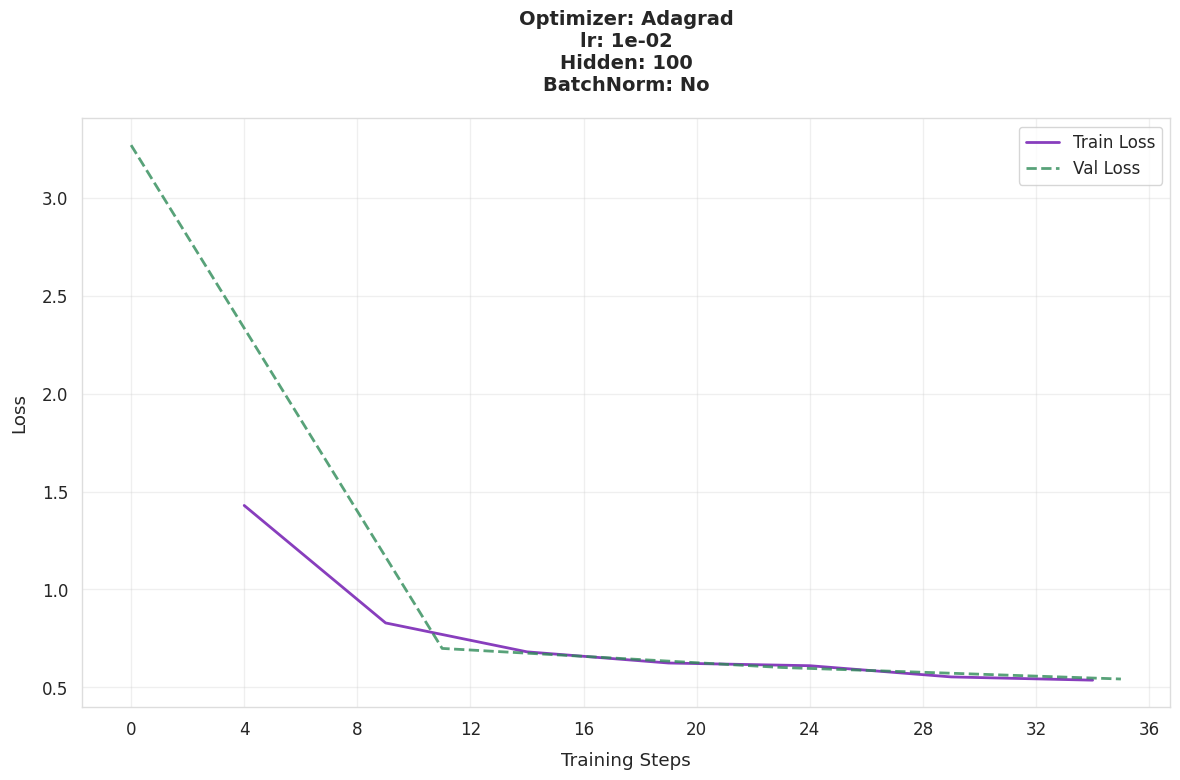

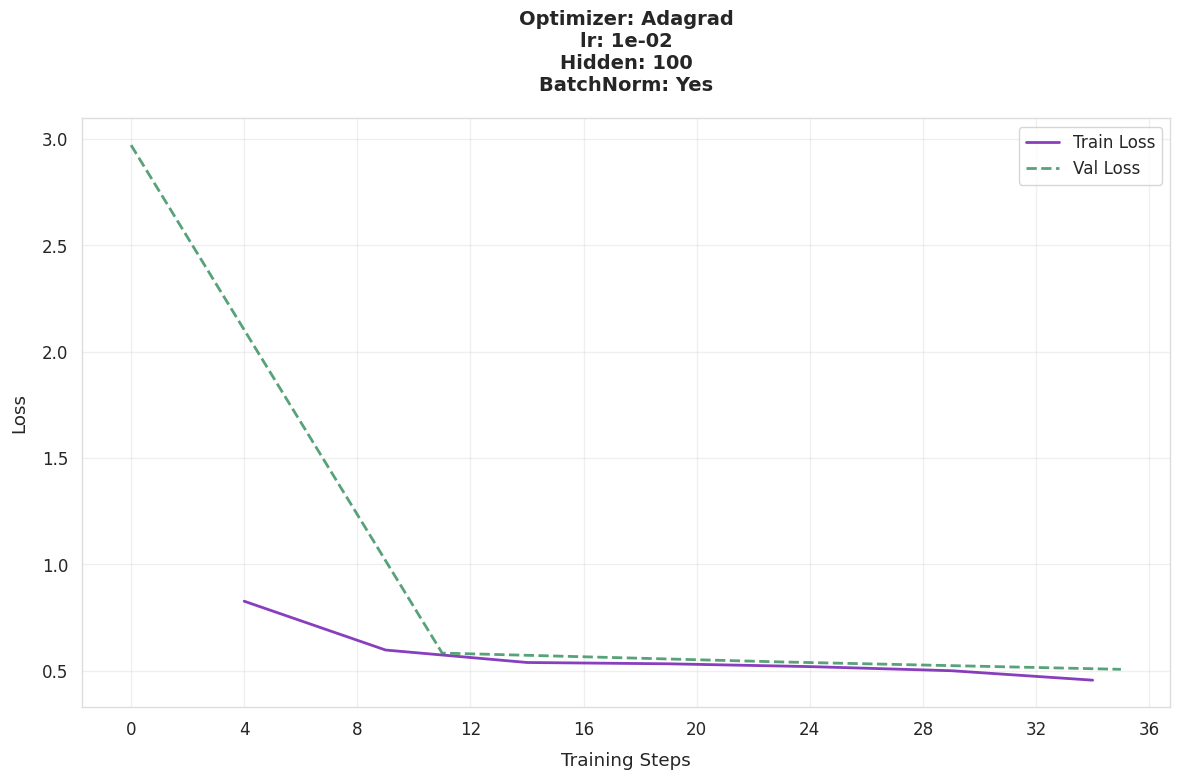

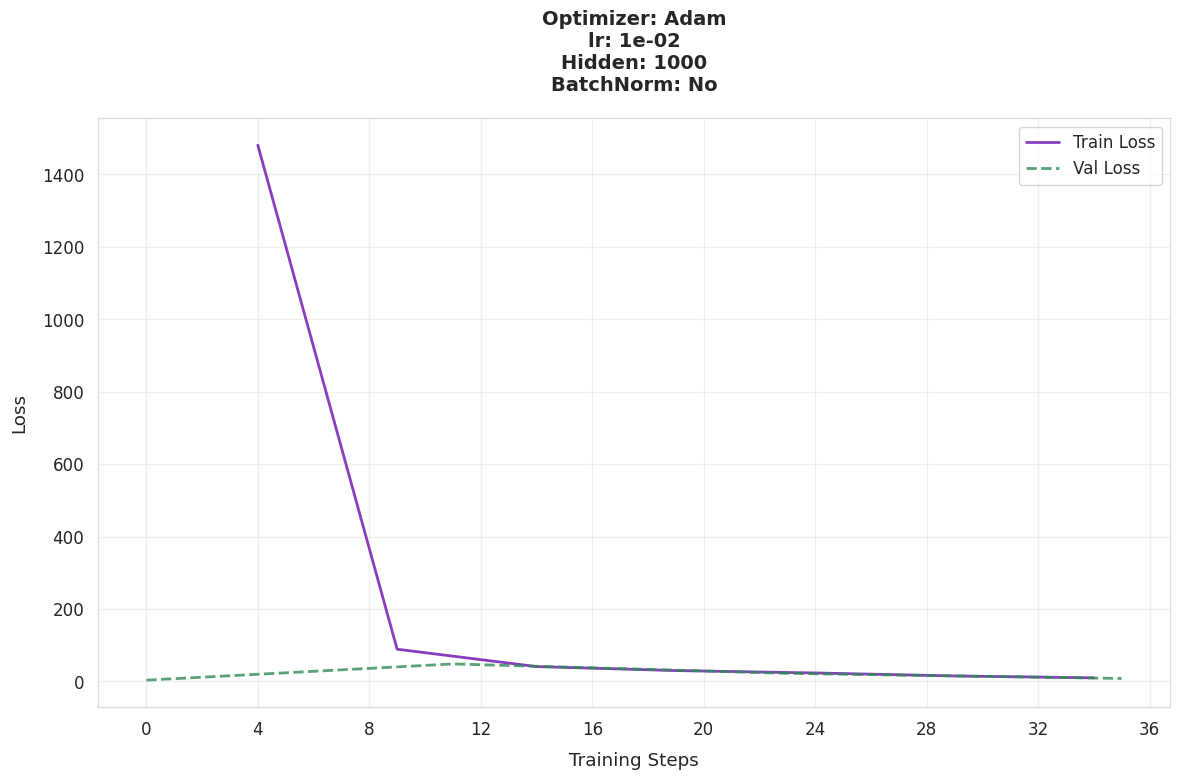

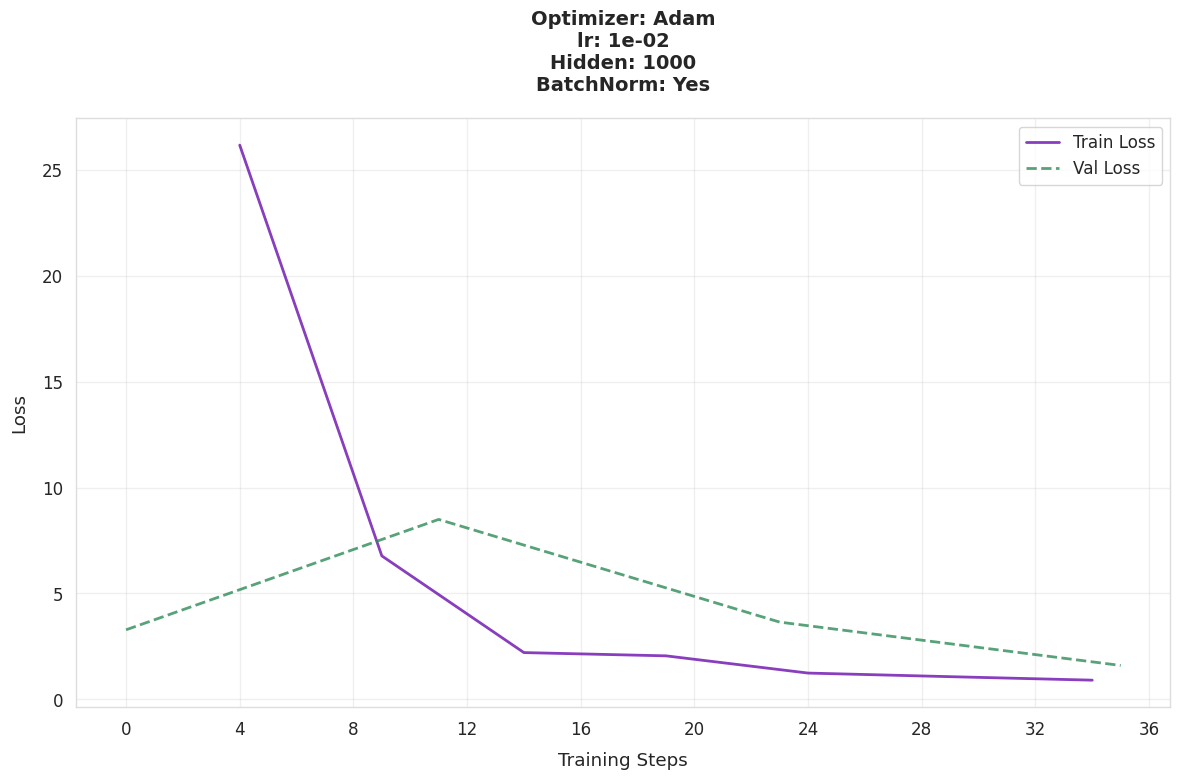

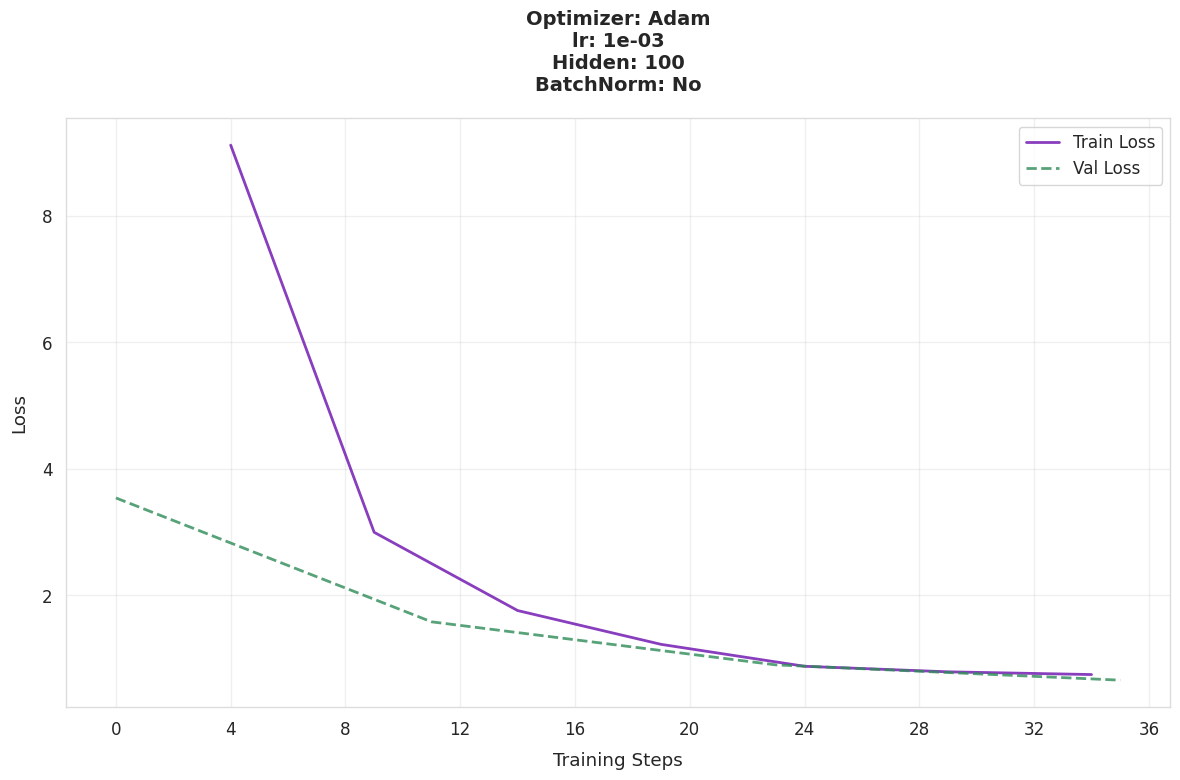

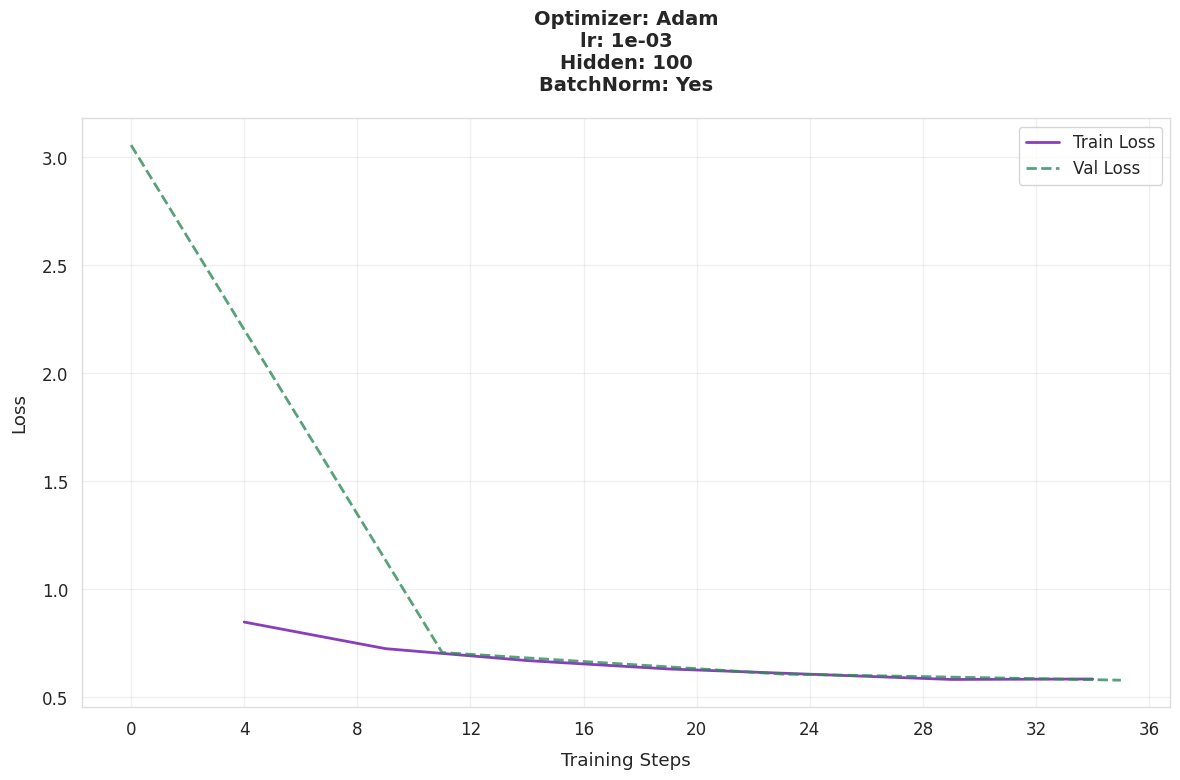

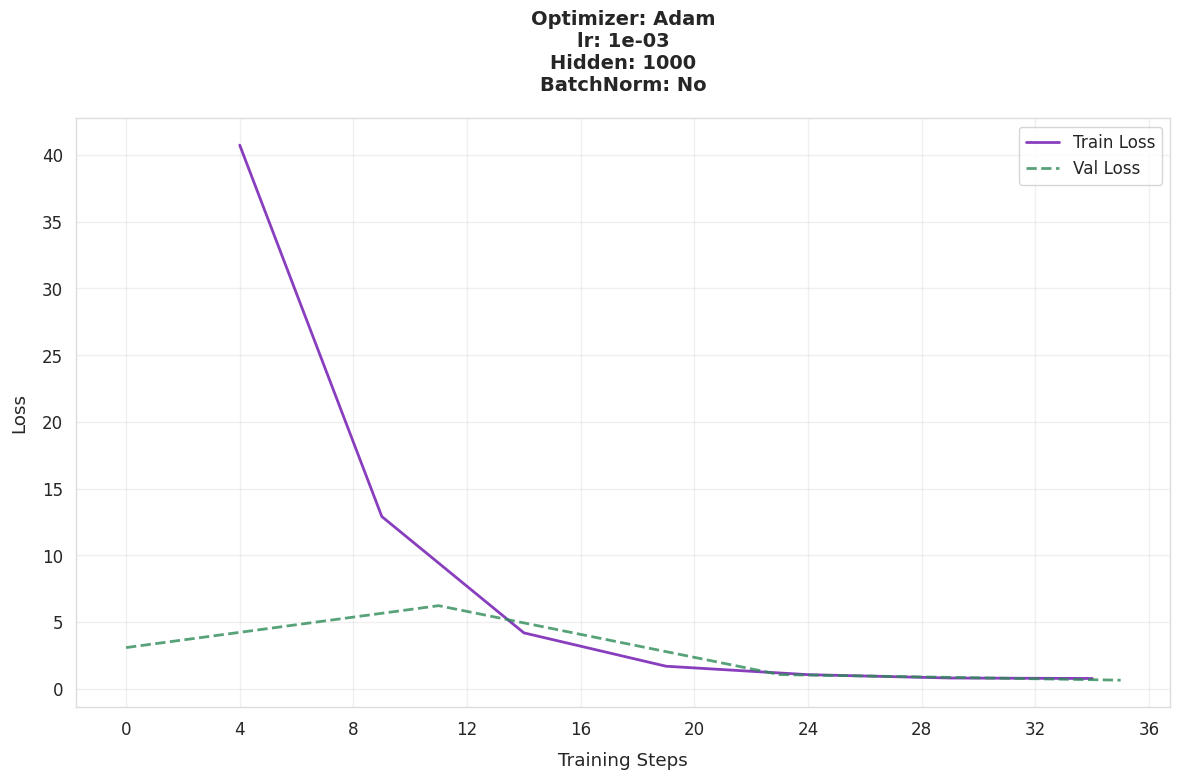

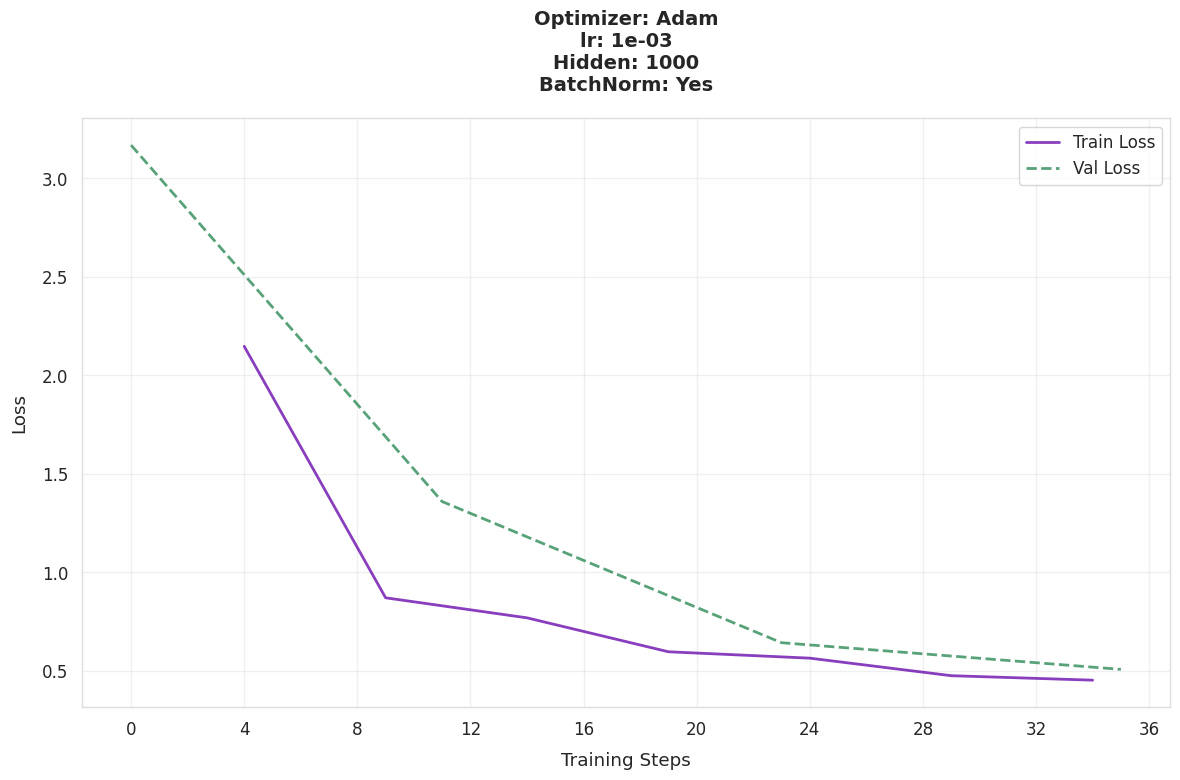

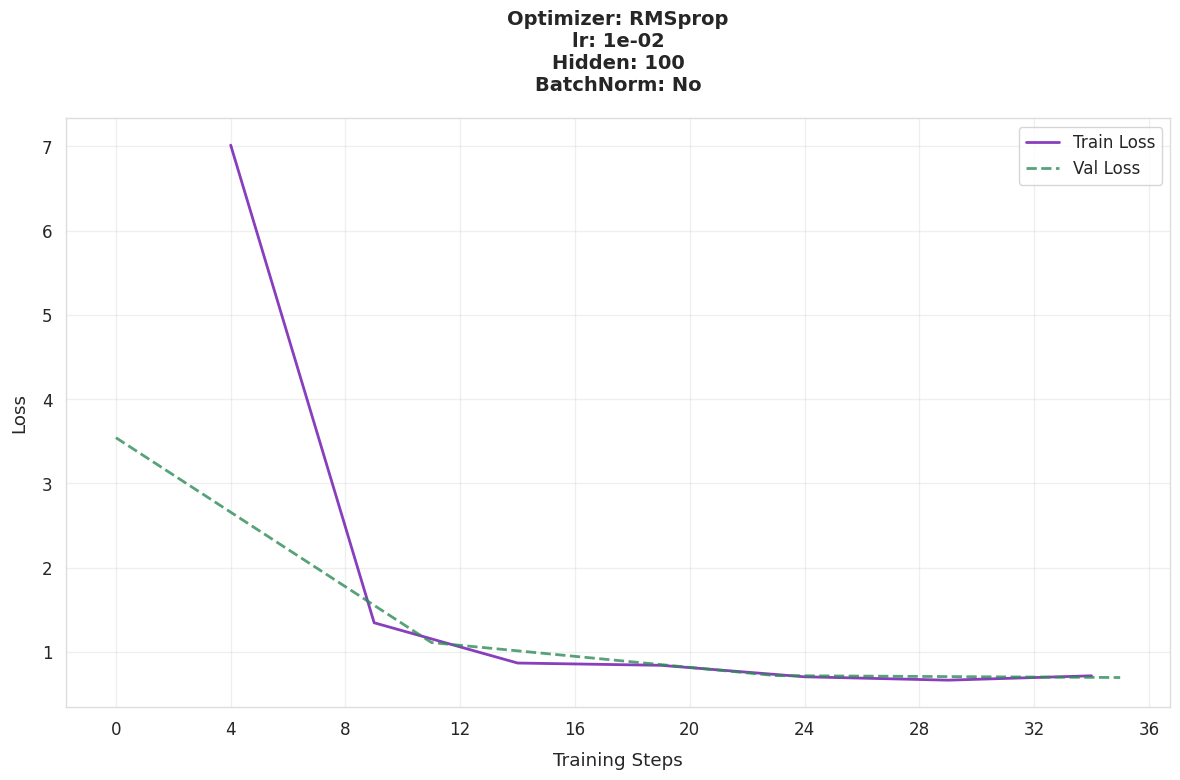

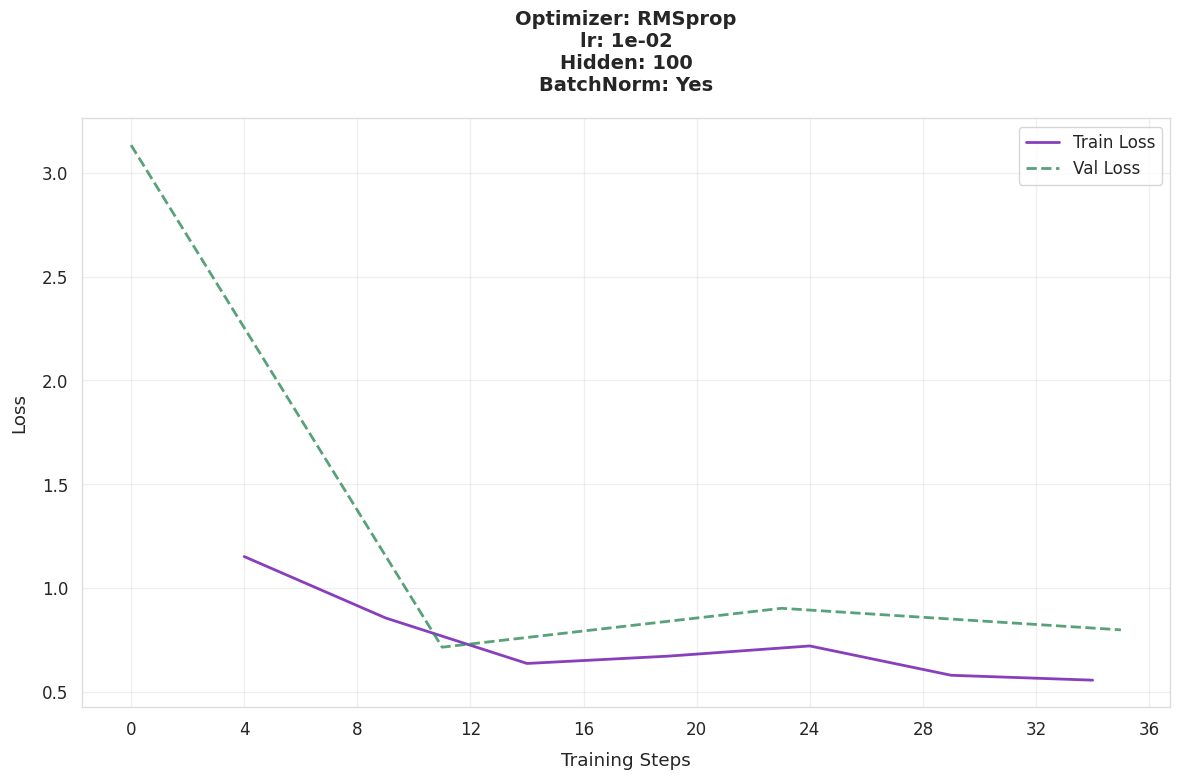

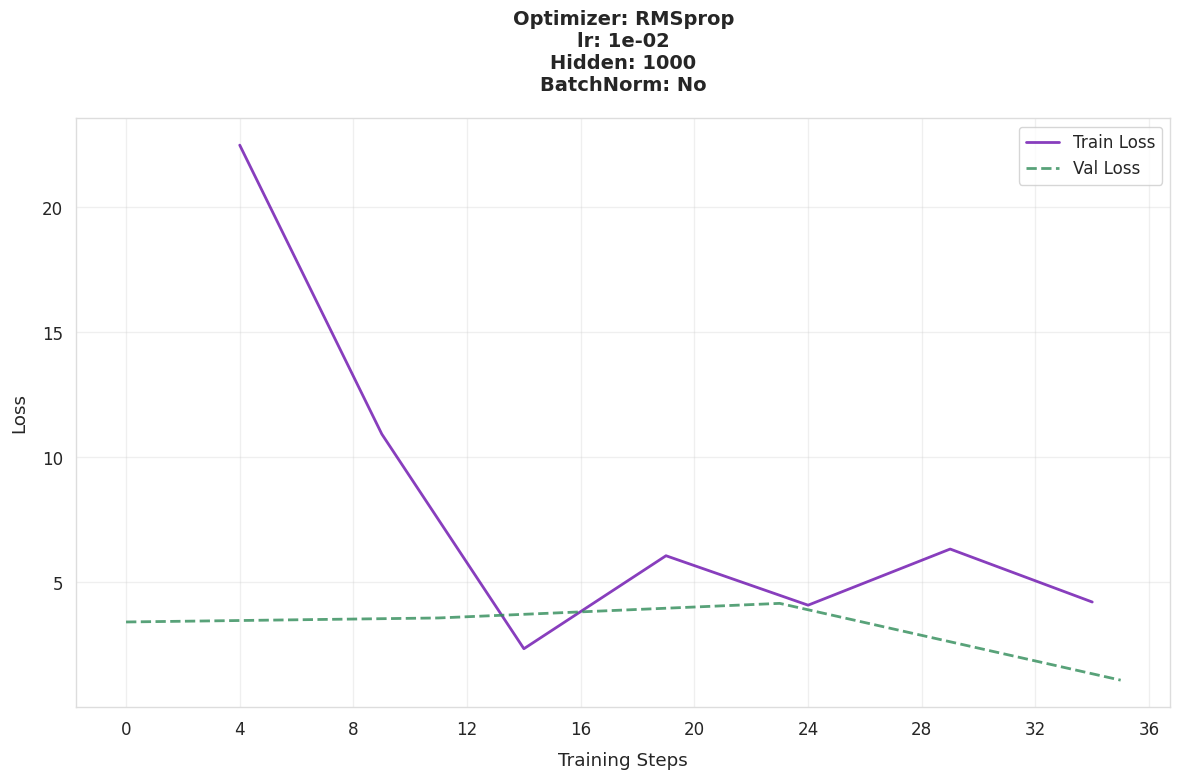

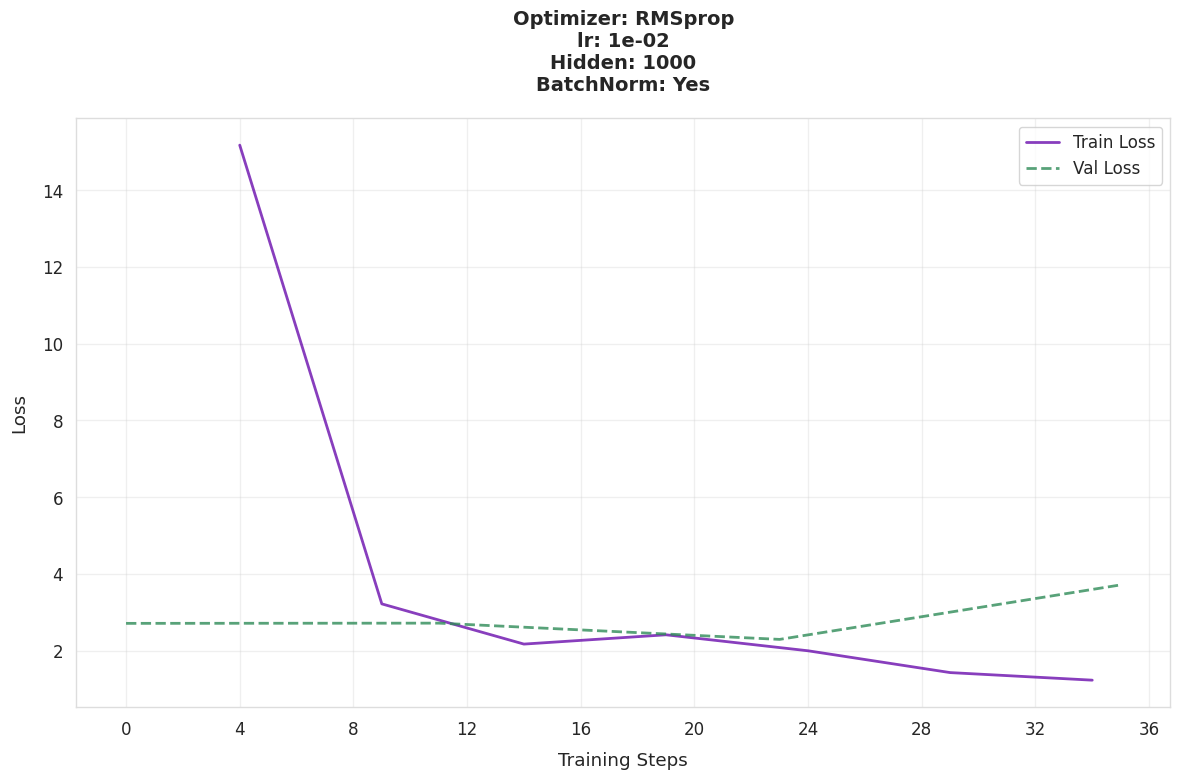

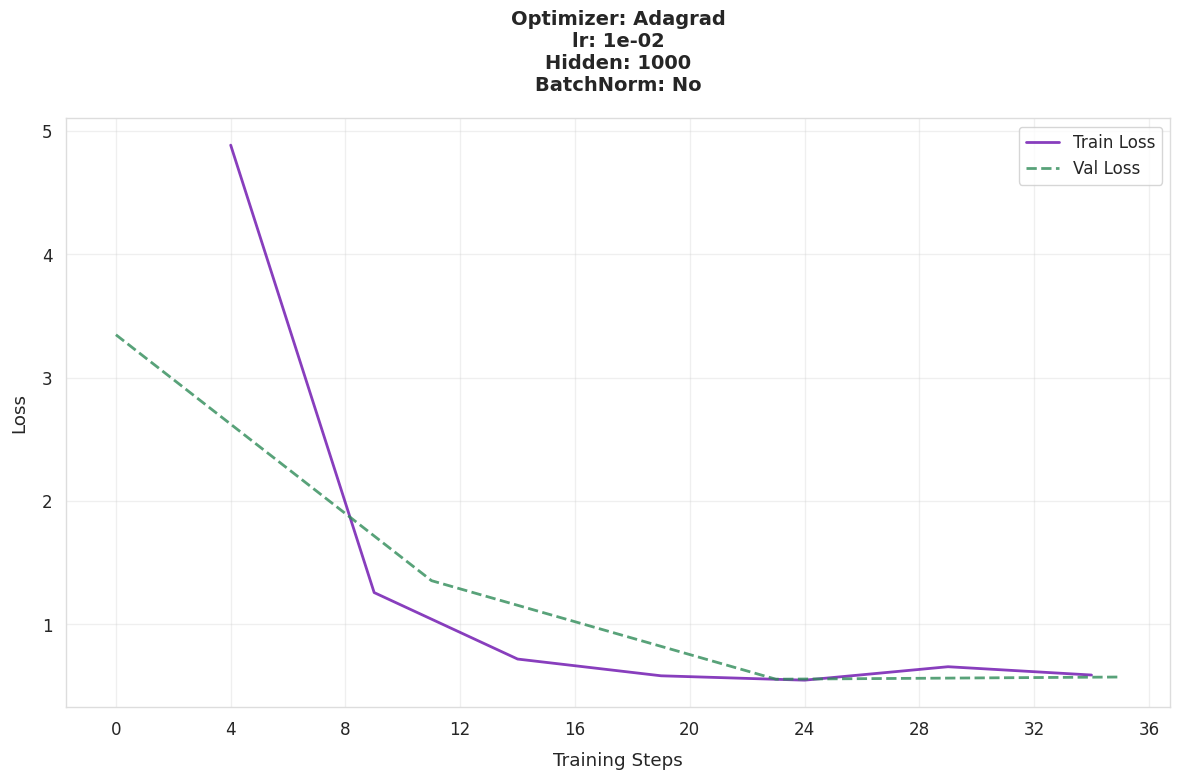

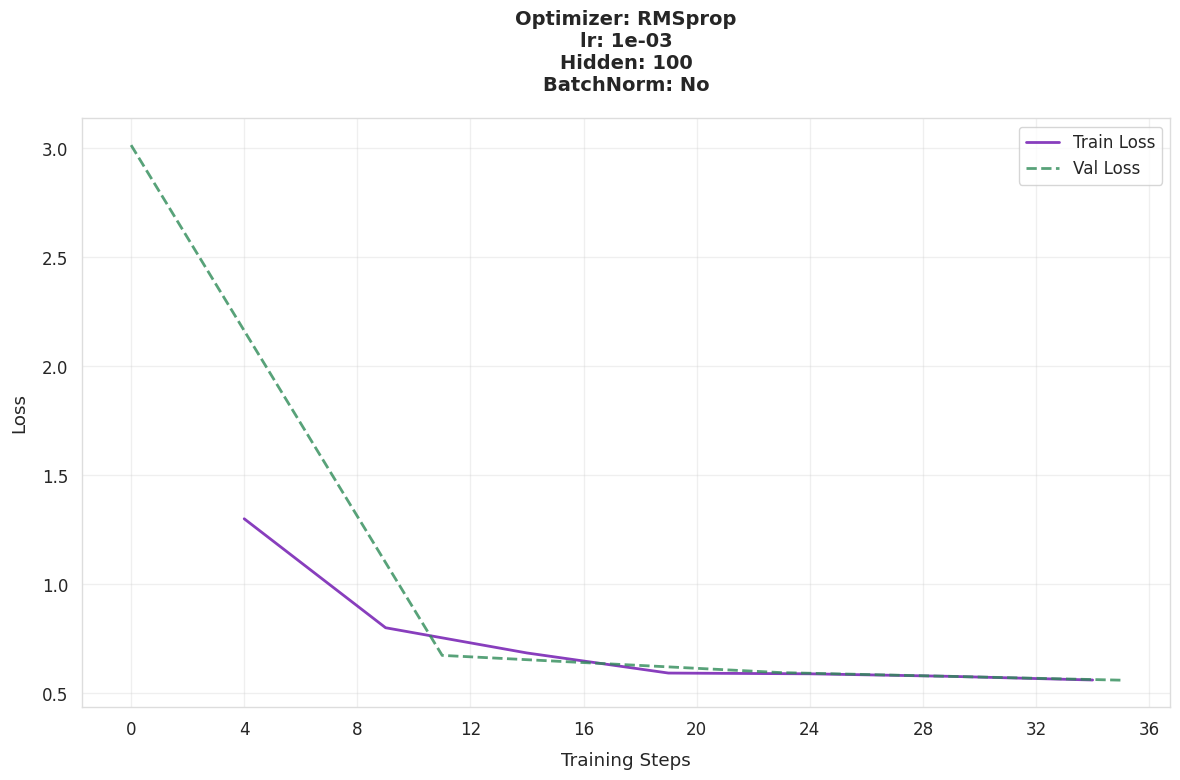

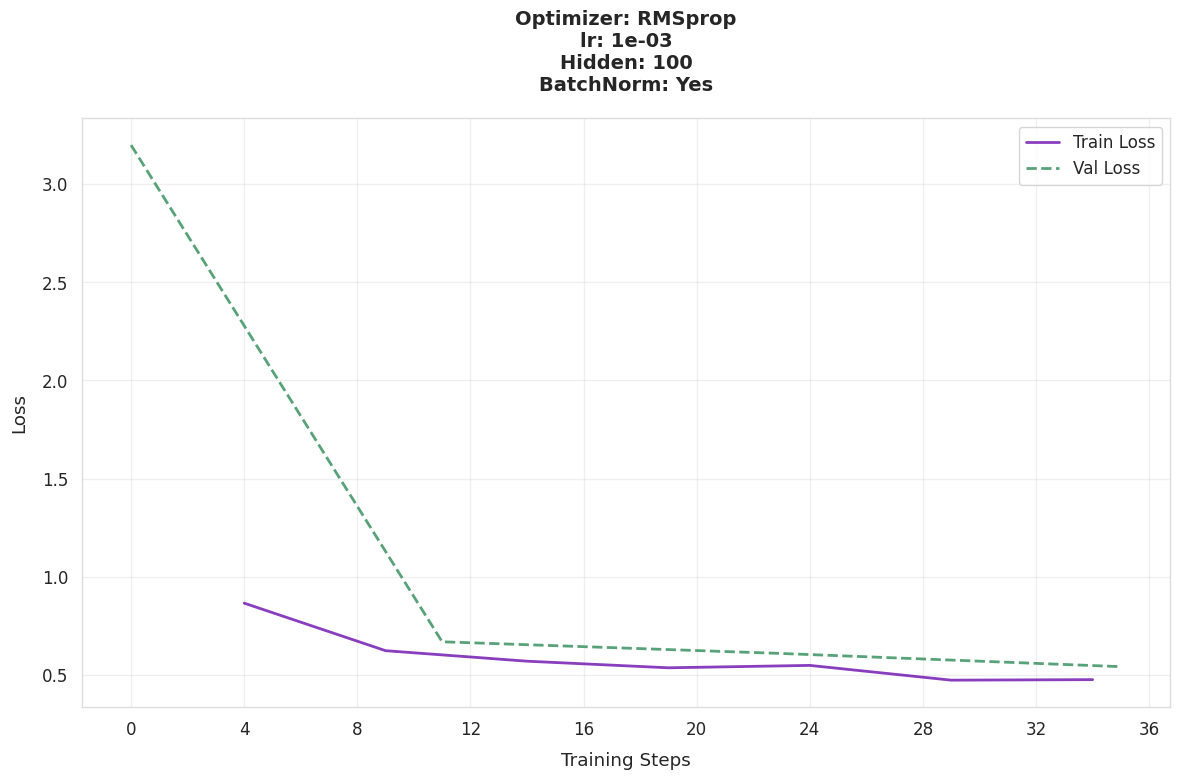

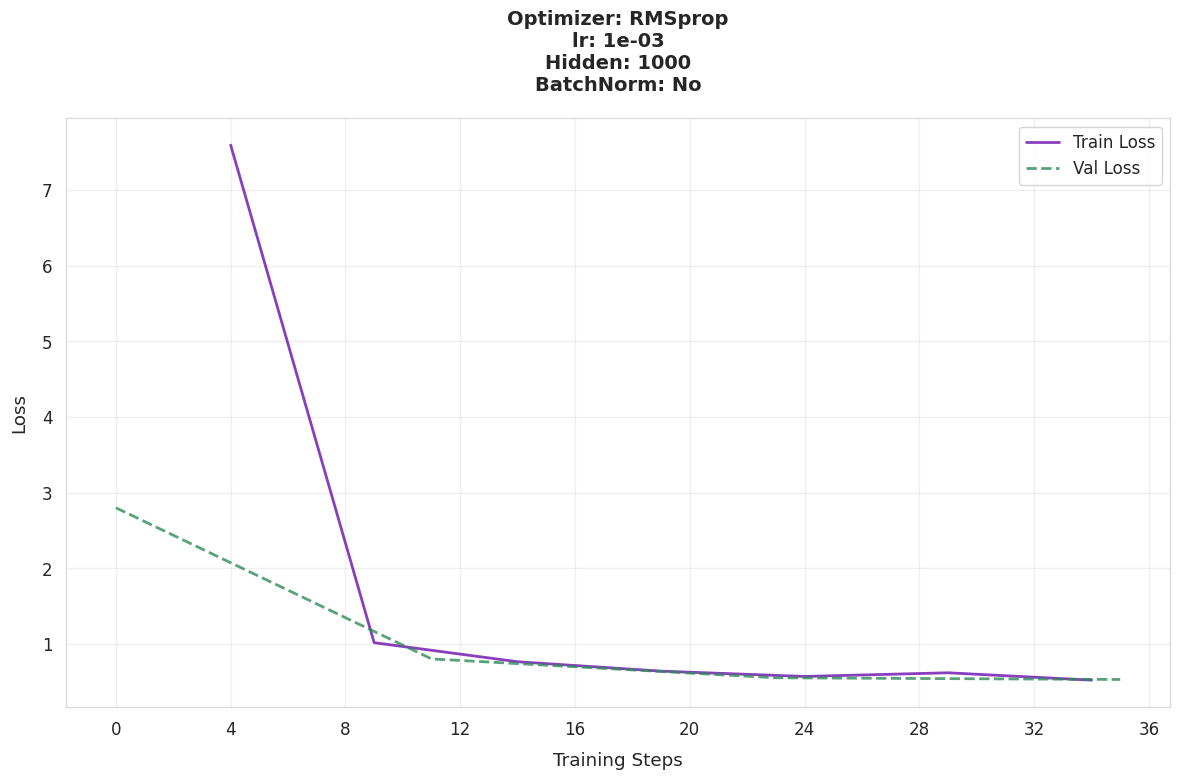

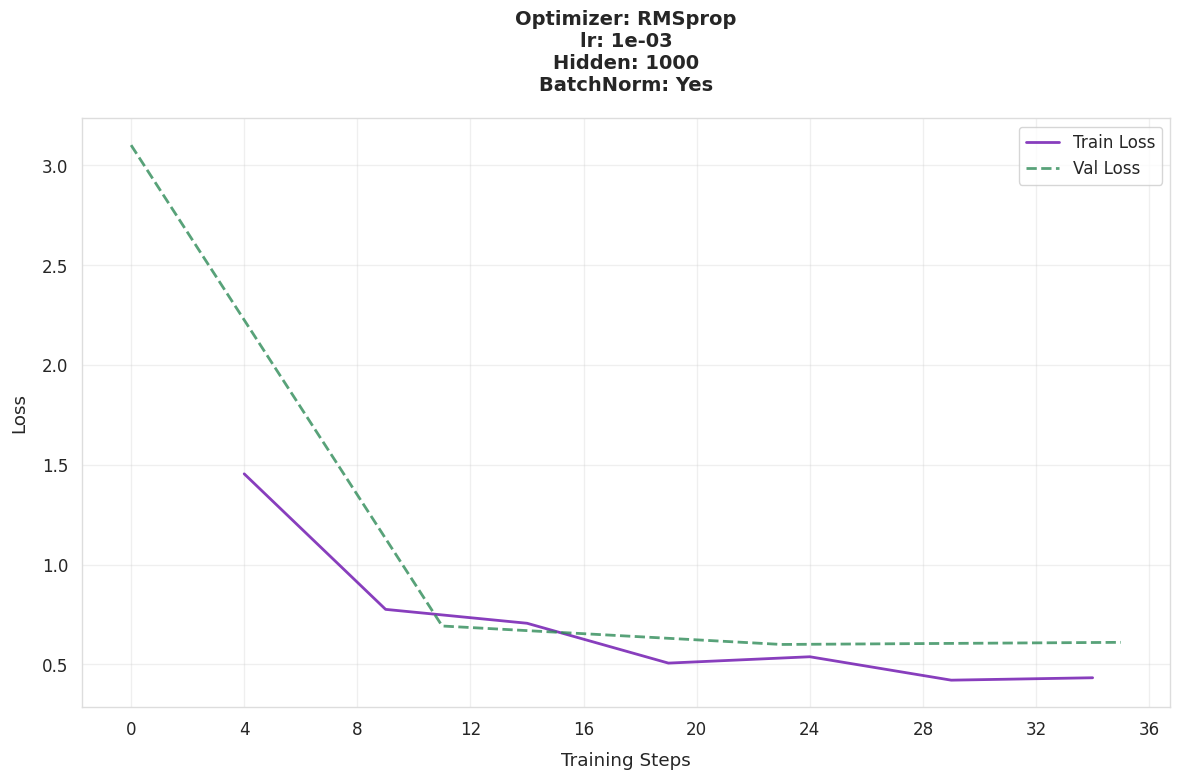

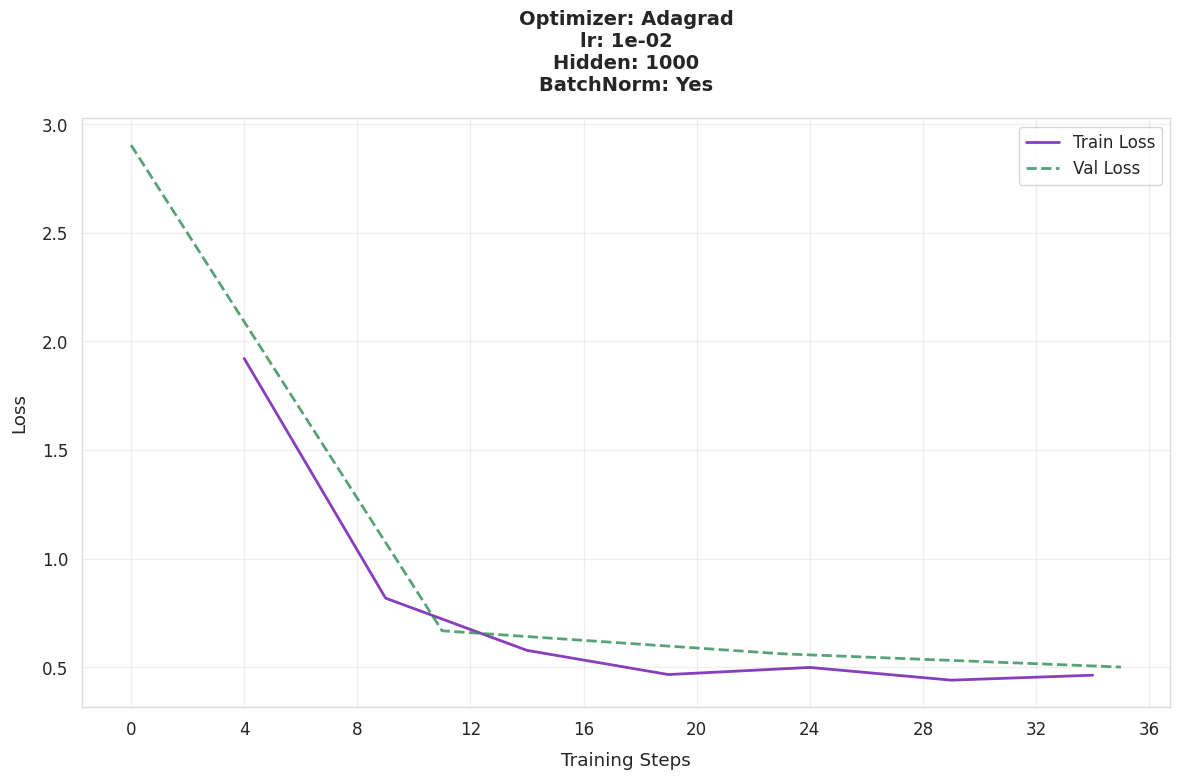

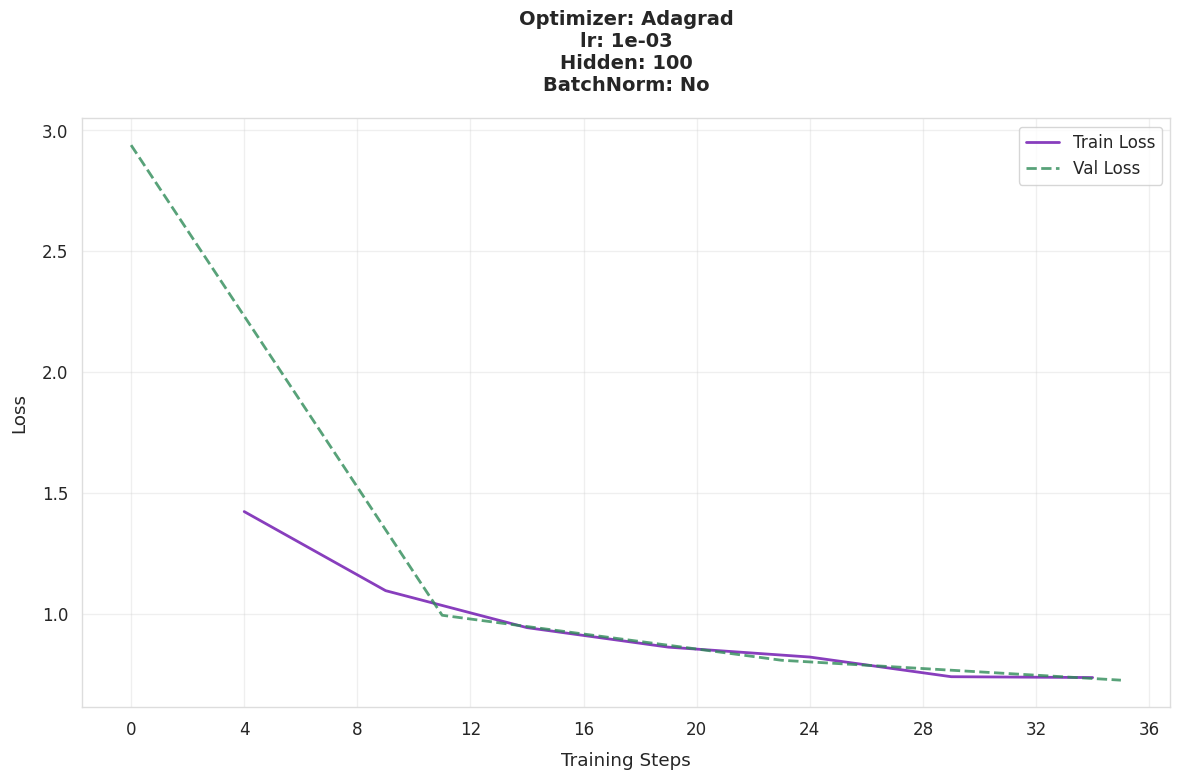

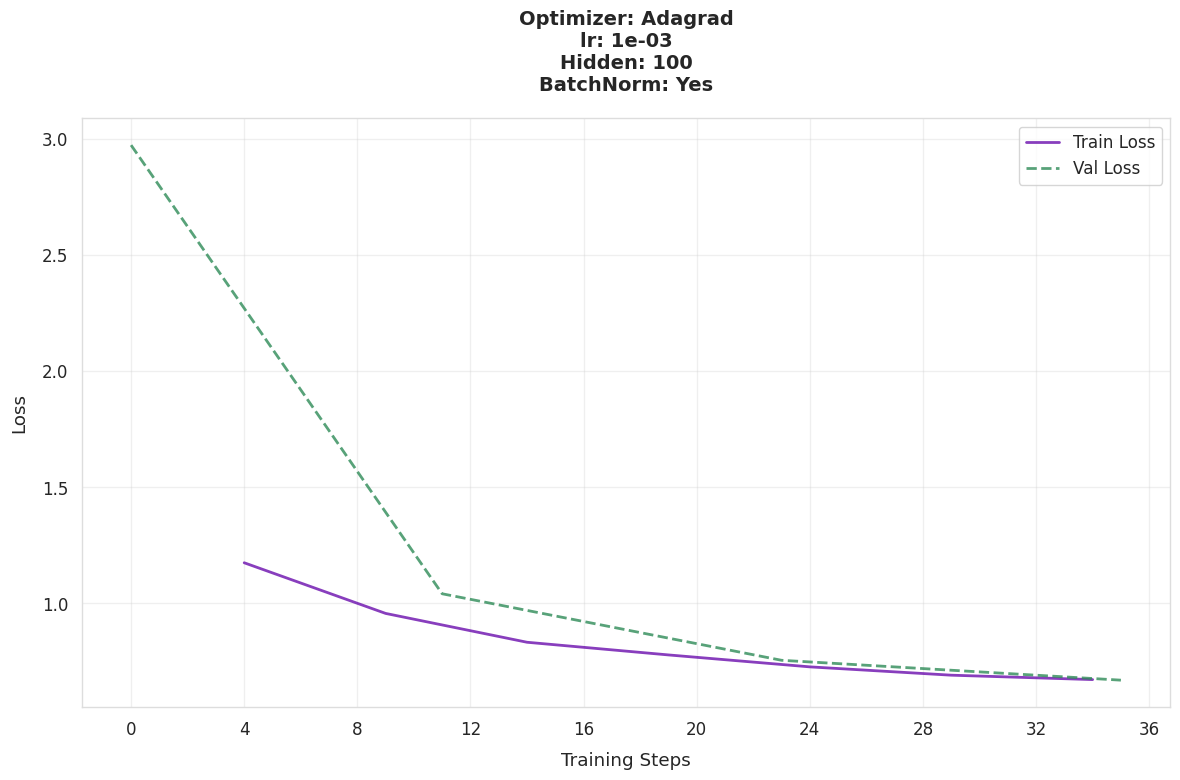

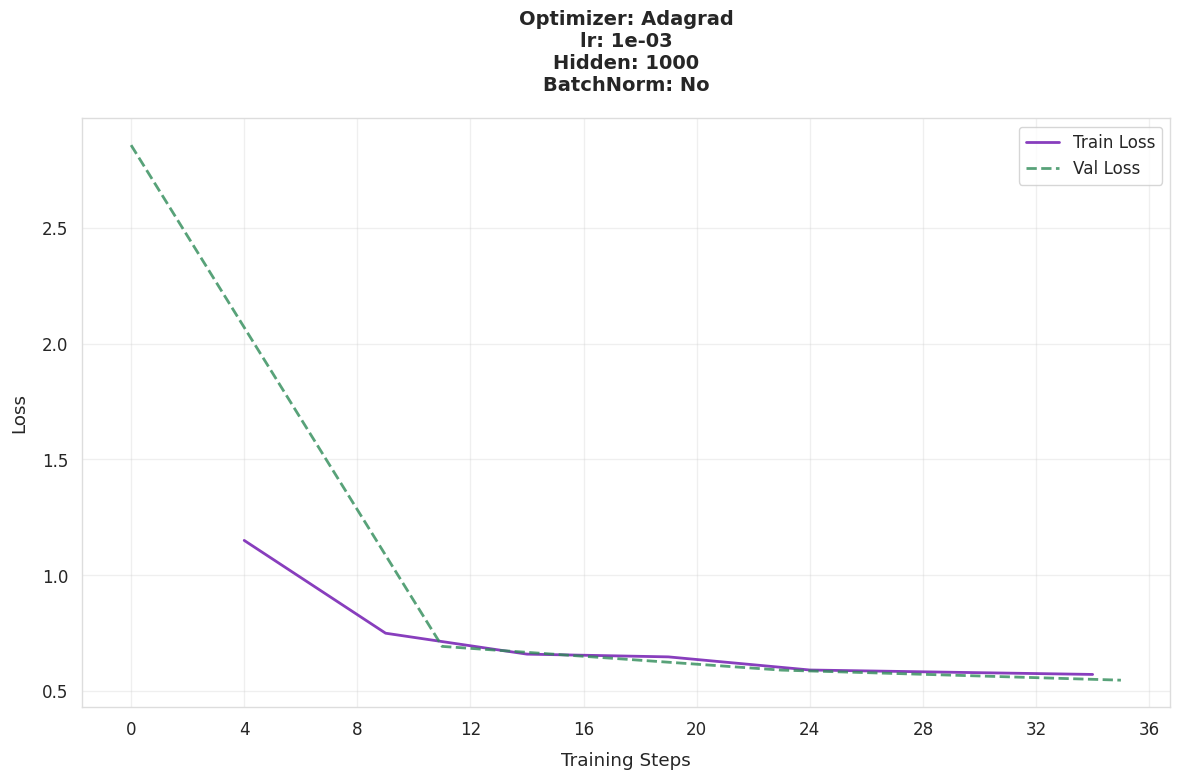

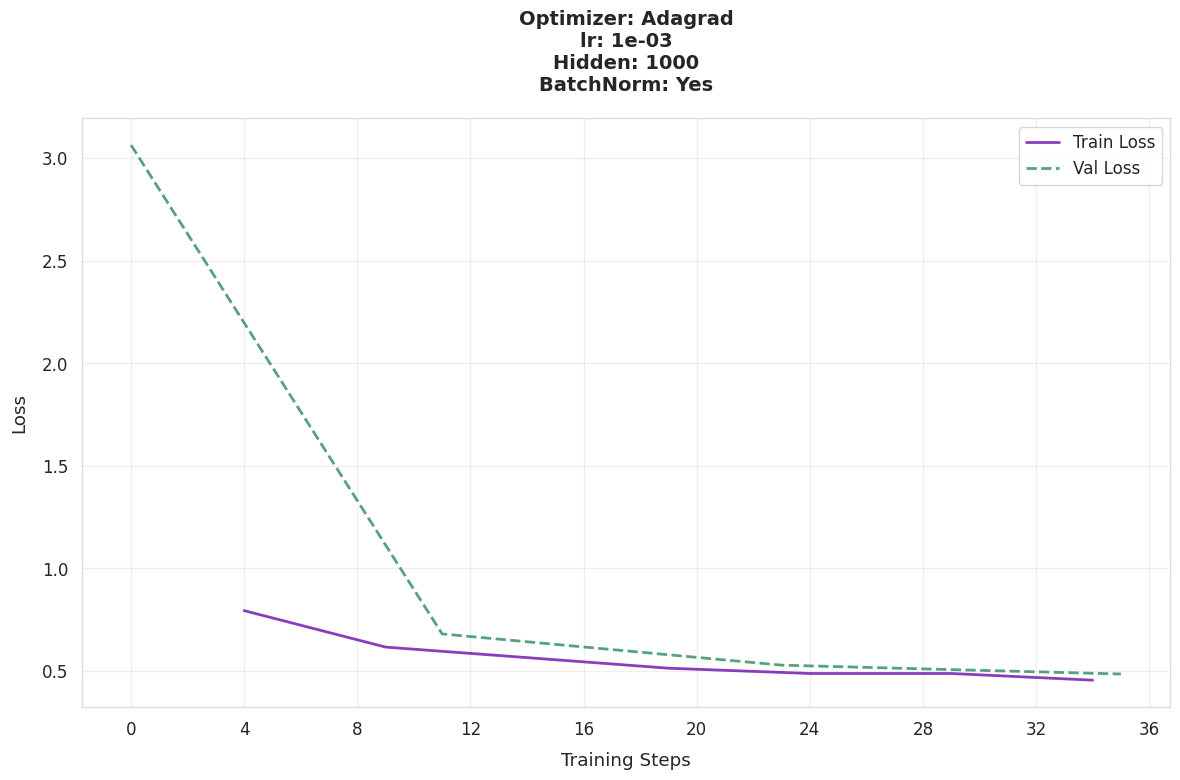

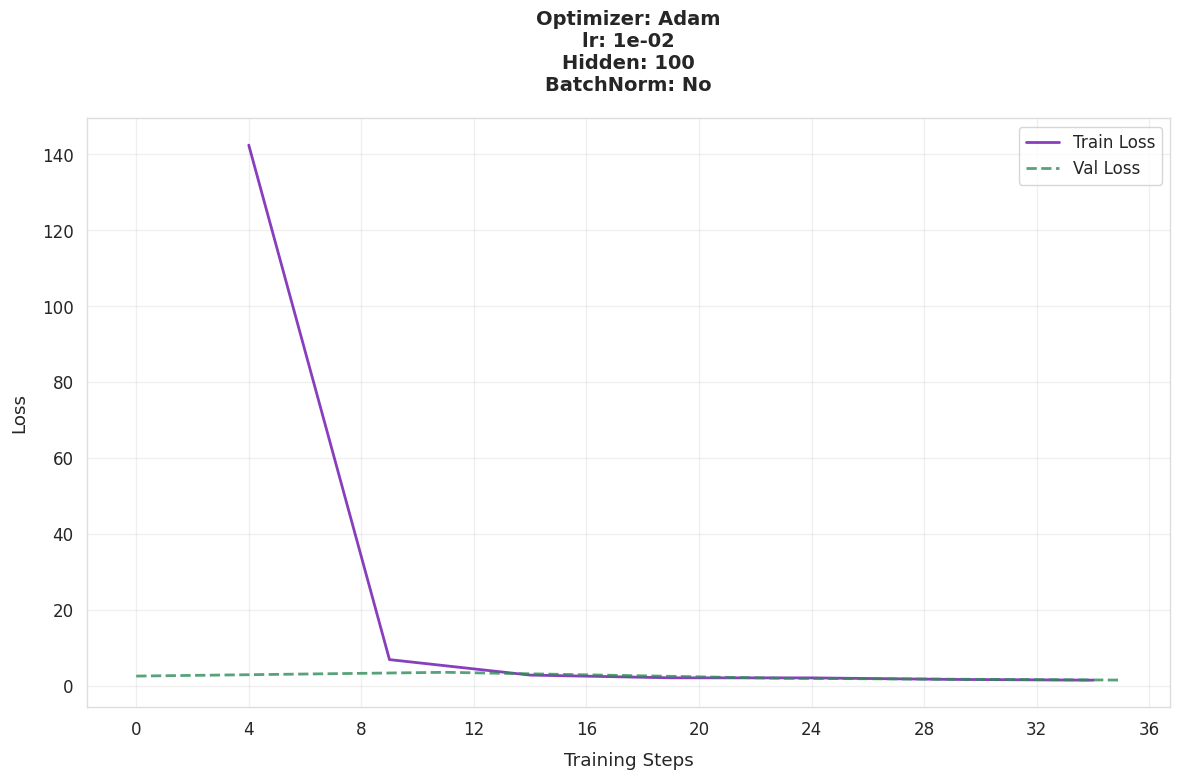

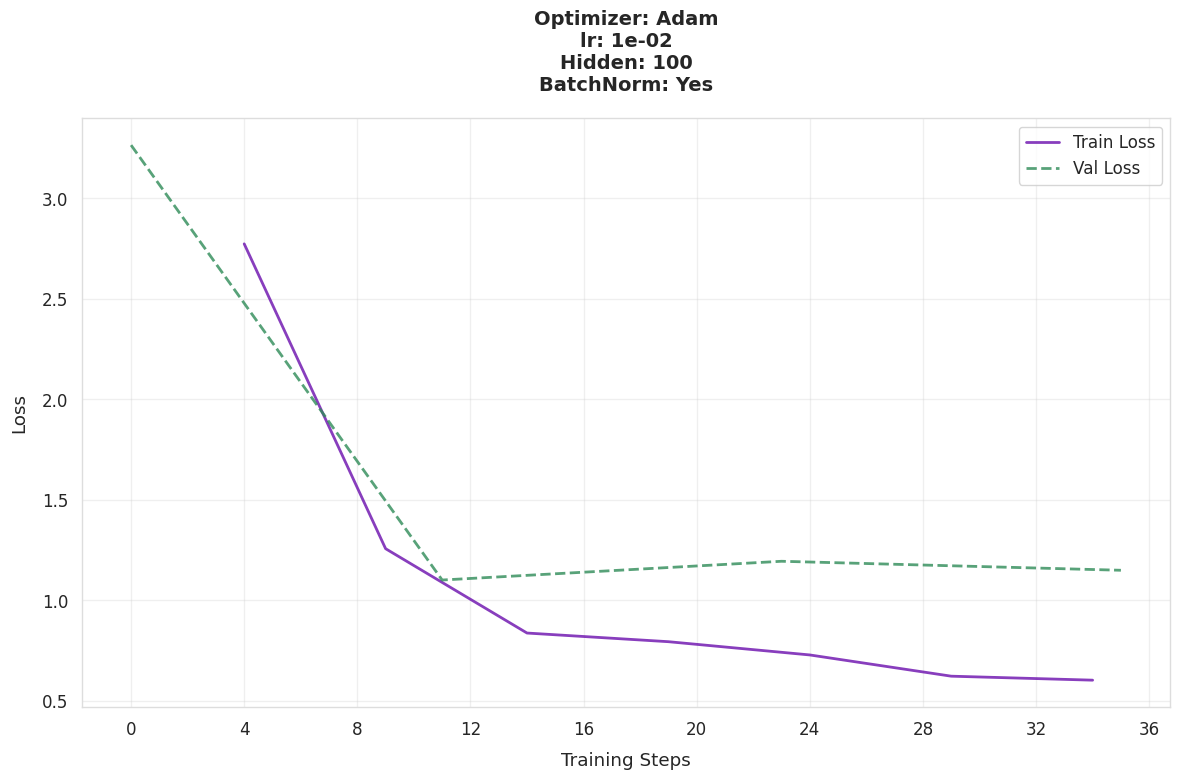

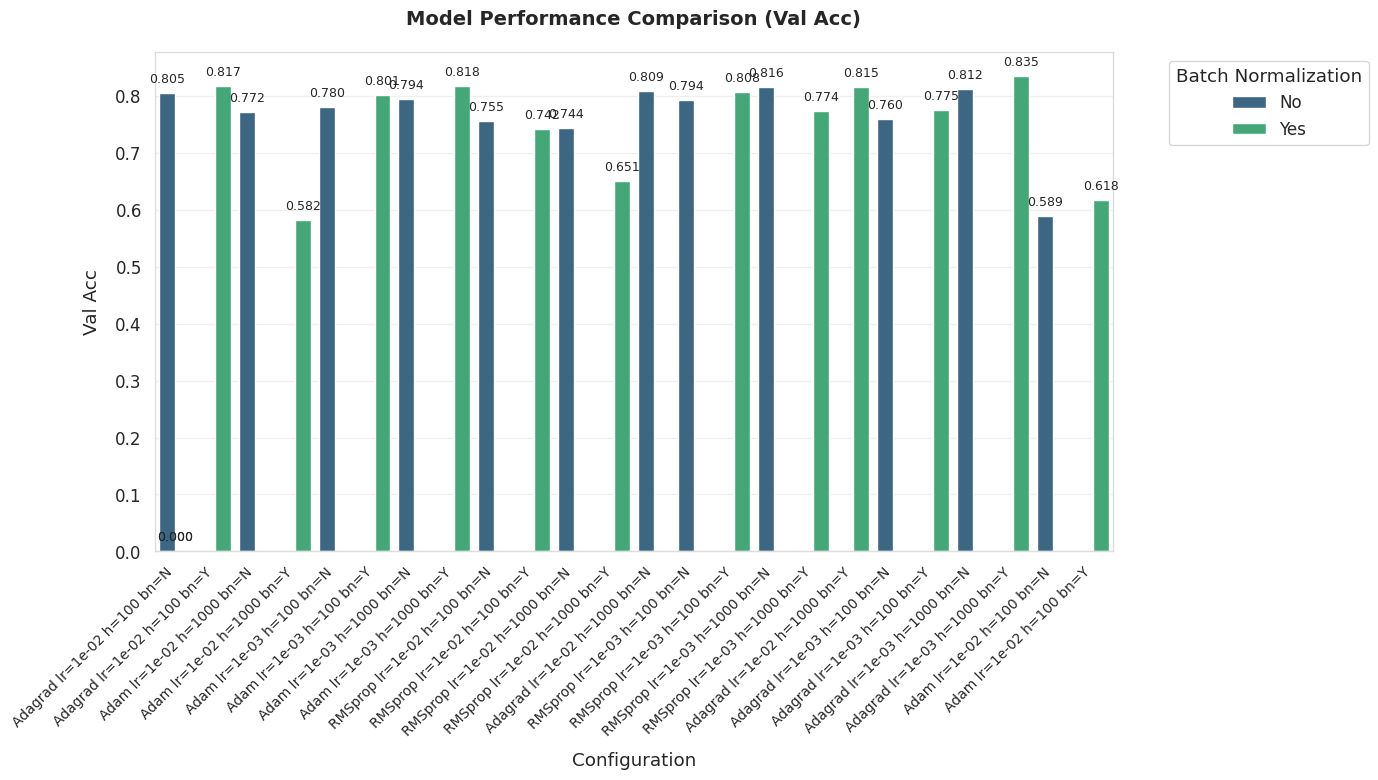


Val Acc Results:
+-----------+---------------+-------------+-----------+---------+
| Optimizer | Learning Rate | Hidden Size | BatchNorm | Val_Acc |
+-----------+---------------+-------------+-----------+---------+
|  Adagrad  |     1e-02     |     100     |    No     | 0.8052  |
|  Adagrad  |     1e-02     |     100     |    Yes    | 0.8175  |
|   Adam    |     1e-02     |    1000     |    No     | 0.7725  |
|   Adam    |     1e-02     |    1000     |    Yes    | 0.5824  |
|   Adam    |     1e-03     |     100     |    No     | 0.7804  |
|   Adam    |     1e-03     |     100     |    Yes    | 0.8014  |
|   Adam    |     1e-03     |    1000     |    No     | 0.7942  |
|   Adam    |     1e-03     |    1000     |    Yes    | 0.8182  |
|  RMSprop  |     1e-02     |     100     |    No     | 0.7552  |
|  RMSprop  |     1e-02     |     100     |    Yes    | 0.7420  |
|  RMSprop  |     1e-02     |    1000     |    No     | 0.7442  |
|  RMSprop  |     1e-02     |    1000     |    Yes    | 0.

In [23]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


LOSS_COLORS = {
    'train': '#6a0dad',
    'val': '#2e8b57'
}

def plot_individual_training_results(versions):
    for version in versions:
        plt.figure(figsize=(12, 8))
        df = pd.read_csv(os.path.join(version, "metrics.csv"))
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        train_df = df.dropna(subset=["train_loss"])
        val_df = df.dropna(subset=["val_loss"])
        
        plt.plot(
            train_df["step"],
            train_df["train_loss"],
            color=LOSS_COLORS['train'],
            linestyle='-',
            linewidth=2,
            alpha=0.8,
            label='Train Loss'
        )
        
        plt.plot(
            val_df["step"],
            val_df["val_loss"],
            color=LOSS_COLORS['val'],
            linestyle='--',
            linewidth=2,
            alpha=0.8,
            label='Val Loss'
        )
        
        title_parts = [
            f"Optimizer: {hparams['optimizer']}",
            f"lr: {hparams['lr']:.0e}",
            f"Hidden: {hparams['hidden_size']}",
            f"BatchNorm: {'Yes' if hparams['batch_normalization'] else 'No'}"
        ]
        plt.title("\n".join(title_parts), pad=20, fontsize=14, fontweight='bold')
        
        plt.xlabel("Training Steps", labelpad=10)
        plt.ylabel("Loss", labelpad=10)
        plt.legend(loc='upper right')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for spine in plt.gca().spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('#dddddd')
            spine.set_linewidth(1)
        
        plt.tight_layout()
        plt.show()

def plot_performance_comparison(versions, metric='val_acc'):
    data = []
    for version in versions:
        df = pd.read_csv(os.path.join(version, "metrics.csv")).dropna(subset=[metric])
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        best_metric = df[metric].max() if 'acc' in metric else df[metric].min()
        data.append({
            'Optimizer': hparams['optimizer'],
            'lr': f"{hparams['lr']:.0e}",
            'Hidden Size': hparams['hidden_size'],
            'BatchNorm': 'Yes' if hparams['batch_normalization'] else 'No',
            metric: best_metric,
            'Config': f"{hparams['optimizer']} lr={hparams['lr']:.0e} h={hparams['hidden_size']} bn={'Y' if hparams['batch_normalization'] else 'N'}"
        })
    
    df = pd.DataFrame(data)
    plt.figure(figsize=(14, 8))
    
    ax = sns.barplot(
        x='Config',
        y=metric,
        hue='BatchNorm',
        data=df,
        palette='viridis',
        dodge=True,
        width=0.8
    )
    
    plt.title(f"Model Performance Comparison ({metric.replace('_', ' ').title()})", 
              pad=20, fontsize=14, fontweight='bold')
    plt.xlabel("Configuration", labelpad=10)
    plt.ylabel(metric.replace('_', ' ').title(), labelpad=10)
    
    plt.xticks(
        rotation=45,
        ha='right',
        fontsize=10
    )
    
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points',
            fontsize=9
        )
    
    plt.legend(
        title='Batch Normalization',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    
    plt.subplots_adjust(bottom=0.25, right=0.85)
    
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('#dddddd')
        spine.set_linewidth(1)
    
    plt.tight_layout()
    plt.show()

def print_results_table(versions, metric='test_acc'):
    table_data = []
    for version in versions:
        df = pd.read_csv(os.path.join(version, "metrics.csv")).dropna(subset=[metric])
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        best_metric = df[metric].max() if 'acc' in metric else df[metric].min()
        table_data.append([
            hparams['optimizer'],
            f"{hparams['lr']:.0e}",
            hparams['hidden_size'],
            'Yes' if hparams['batch_normalization'] else 'No',
            f"{best_metric:.4f}"
        ])
    
    print(f"\n{metric.replace('_', ' ').title()} Results:")
    print(tabulate(
        table_data,
        headers=['Optimizer', 'Learning Rate', 'Hidden Size', 'BatchNorm', metric.title()],
        tablefmt='pretty',
        floatfmt=".4f"
    ))

class HyperparameterGrid:
    def __init__(self):
        self.optimizers = [
            ("Adagrad", optim.Adagrad),
            ("Adam", Adam),
            ("RMSprop", optim.RMSprop),
        ]
        self.learning_rates = [0.01, 0.001]
        self.hidden_sizes = [100, 1000]
        self.batch_norm_options = [False, True]
        
    def generate_configs(self):
        return list(itertools.product(
            self.optimizers,
            self.learning_rates,
            self.hidden_sizes,
            self.batch_norm_options
        ))
    
    def get_total_runs(self):
        return (len(self.optimizers) * len(self.learning_rates) * 
                len(self.hidden_sizes) * len(self.batch_norm_options))

hp_grid = HyperparameterGrid()
print(f"Total experiments to run: {hp_grid.get_total_runs()}")

for config in hp_grid.generate_configs():
    optimizer, lr, hidden_size, batch_normalization = config
    optimizer_name, optimizer_class = optimizer
    
    print(f"\nTraining with: {optimizer_name}, lr={lr:.0e}, hidden_size={hidden_size}, batch_norm={batch_normalization}")
    
    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=4096, shuffle=True, num_workers=4
    )
    val_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=4096, num_workers=4
    )
    test_loader = torch.utils.data.DataLoader(
        testing_set, batch_size=4096, num_workers=4
    )

    model = LitModel(
        hidden_size=hidden_size,
        batch_normalization=batch_normalization,
        optimizer=optimizer_class,
        lr=lr,
        weight_decay=0.005,
    )

    logger = CSVLogger("logs", name="fashion_mnist_model")
    MAX_EPOCHS = 3
    logger.log_hyperparams({
        "max_epochs": MAX_EPOCHS,
        "lr": lr,
        "optimizer": optimizer_name,
        "hidden_size": hidden_size,
        "batch_normalization": batch_normalization,
    })
    
    trainer = L.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=logger,
        accelerator="cpu",
        log_every_n_steps=5,
        enable_model_summary=False,
        enable_progress_bar=False,
    )
    
    trainer.validate(model, dataloaders=val_loader, verbose=True)
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

versions = sorted(glob("logs/fashion_mnist_model/*/"))
plot_individual_training_results(versions)
plot_performance_comparison(versions, 'val_acc')
print_results_table(versions, 'val_acc')

Исходя из графиков, можно заключить, что лучшими комбинациями оказались:

1. Adagrad | Learning Rate: 0.01 | Hidden Size: 1000 | BatchNorm: Yes

2. Adagrad | Learning Rate: 0.01 | Hidden Size: 100 | BatchNorm: Yes

3. Adagrad | Learning Rate: 0.001 | Hidden Size: 1000 | BatchNorm: Yes

4. RMSprop | Learning Rate: 0.001 | Hidden Size: 100 | BatchNorm: Yes

5. Adam | Learning Rate: 0.001 | Hidden Size: 1000 | BatchNorm: Yes

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



Training best model: optimizer=Adagrad, lr=0.01, hidden_size=1000, batch_norm=True


`Trainer.fit` stopped: `max_epochs=15` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training best model: optimizer=Adagrad, lr=0.01, hidden_size=100, batch_norm=True


`Trainer.fit` stopped: `max_epochs=15` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training best model: optimizer=Adagrad, lr=0.001, hidden_size=1000, batch_norm=True


`Trainer.fit` stopped: `max_epochs=15` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training best model: optimizer=RMSprop, lr=0.001, hidden_size=100, batch_norm=True


`Trainer.fit` stopped: `max_epochs=15` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training best model: optimizer=Adam, lr=0.001, hidden_size=1000, batch_norm=True


`Trainer.fit` stopped: `max_epochs=15` reached.


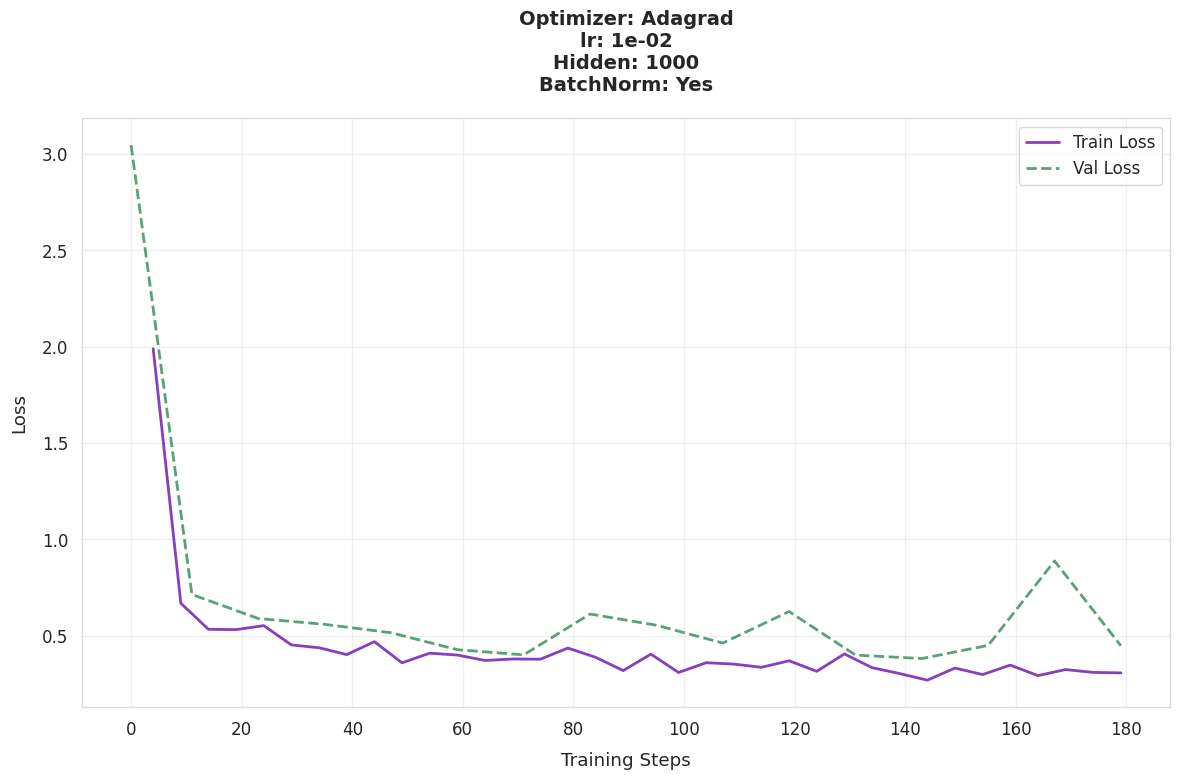

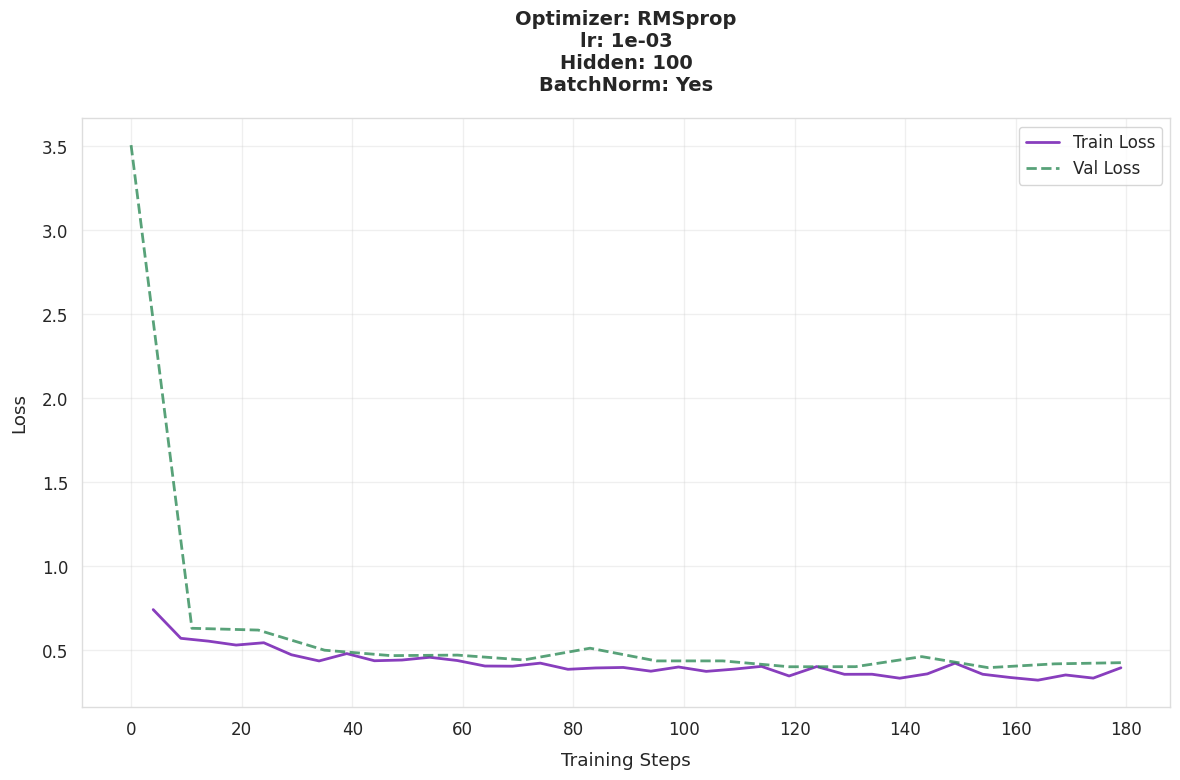

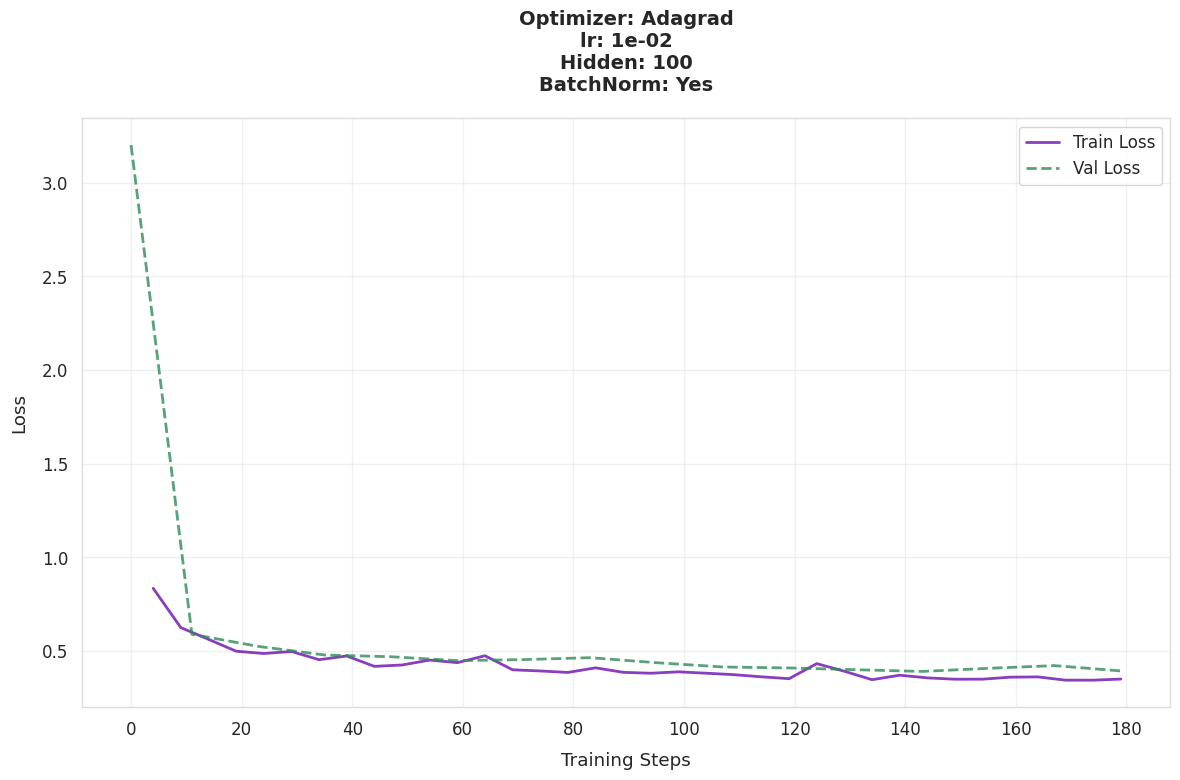

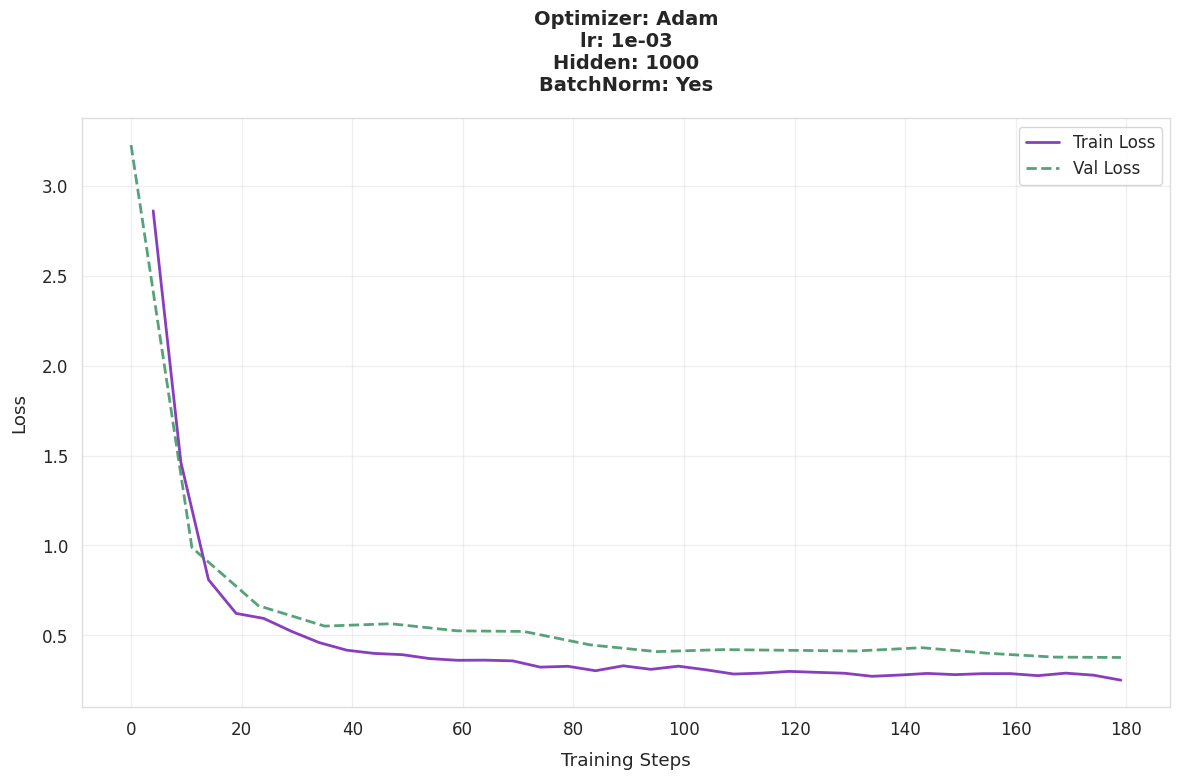

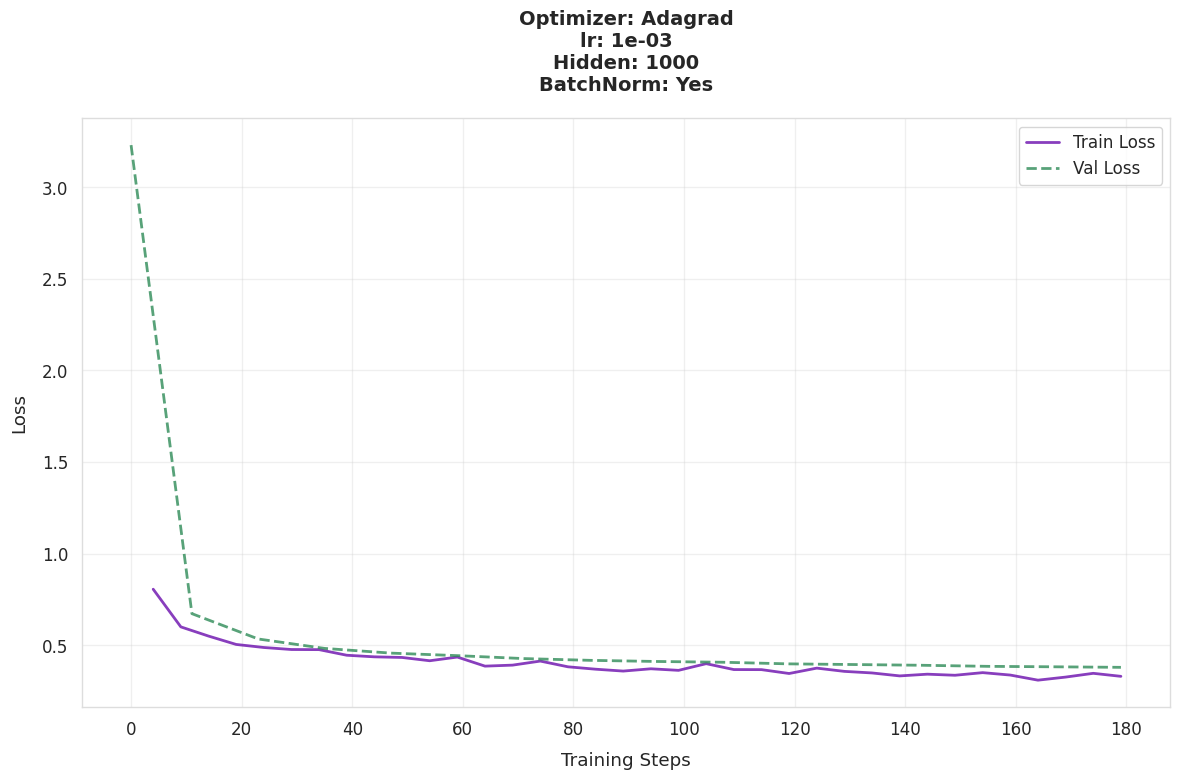

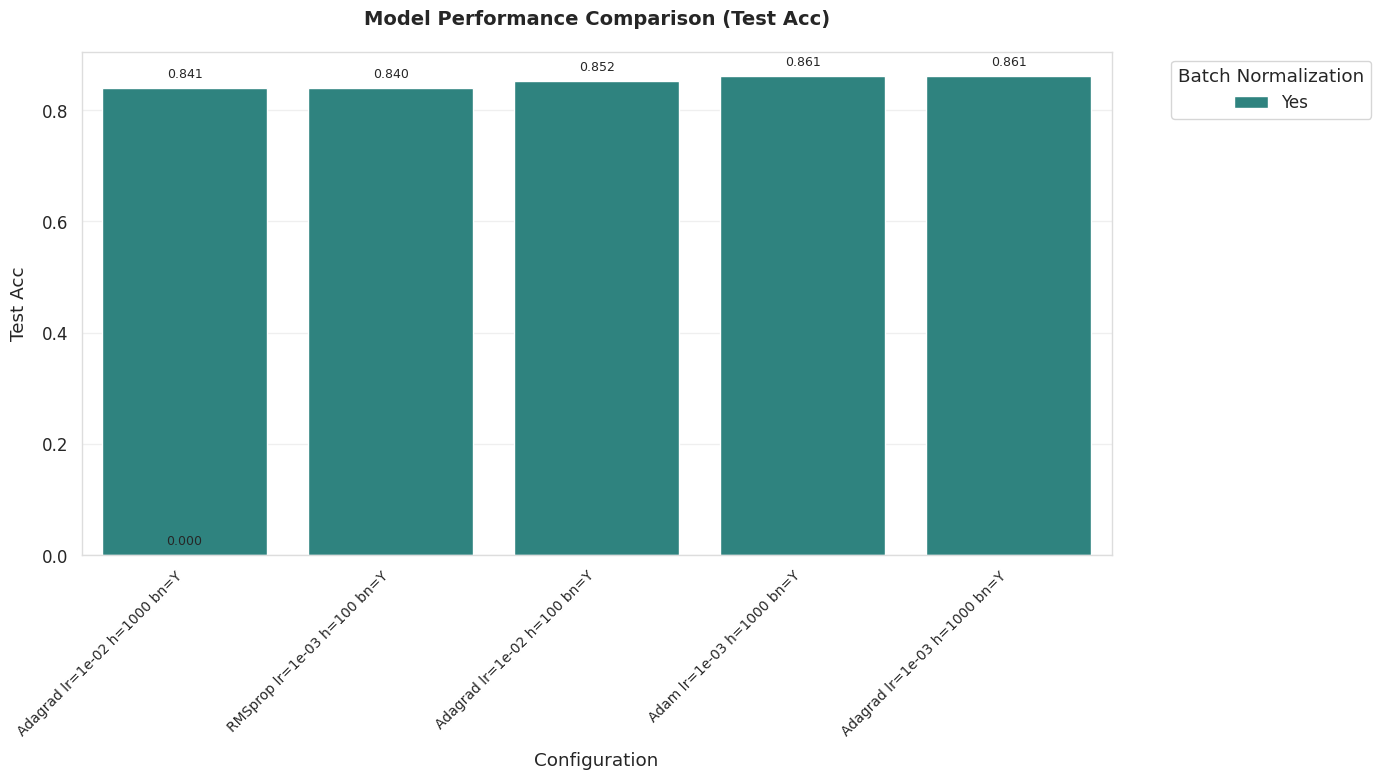


Test Acc Results:
+-----------+---------------+-------------+-----------+----------+
| Optimizer | Learning Rate | Hidden Size | BatchNorm | Test_Acc |
+-----------+---------------+-------------+-----------+----------+
|  Adagrad  |     1e-02     |    1000     |    Yes    |  0.8407  |
|  RMSprop  |     1e-03     |     100     |    Yes    |  0.8402  |
|  Adagrad  |     1e-02     |     100     |    Yes    |  0.8521  |
|   Adam    |     1e-03     |    1000     |    Yes    |  0.8611  |
|  Adagrad  |     1e-03     |    1000     |    Yes    |  0.8611  |
+-----------+---------------+-------------+-----------+----------+


In [24]:
OPTIMAL = [
    (("Adagrad", optim.Adagrad), 0.01, 1000, True),
    (("Adagrad", optim.Adagrad), 0.01, 100, True),
    (("Adagrad", optim.Adagrad), 0.001, 1000, True),
    (("RMSprop", optim.RMSprop), 0.001, 100, True),
    (("Adam", Adam), 0.001, 1000, True)
]

for (optimizer, lr, hidden_size, batch_normalization) in OPTIMAL:
    print(
        f"\nTraining best model: optimizer={optimizer[0]}, lr={lr}, "
        f"hidden_size={hidden_size}, batch_norm={batch_normalization}"
    )
    
    model = LitModel(
        hidden_size=hidden_size,
        batch_normalization=batch_normalization,
        optimizer=optimizer[1],
        lr=lr,
        weight_decay=0.005,
    )

    logger = CSVLogger("logs", name="fashion_mnist_model_selected_params")
    max_epochs = 15
    logger.log_hyperparams({
        "max_epochs": max_epochs,
        "lr": lr,
        "optimizer": optimizer[0],
        "hidden_size": hidden_size,
        "batch_normalization": batch_normalization,
    })
    
    trainer = L.Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator="cpu",
        log_every_n_steps=5,
        enable_model_summary=False,
        enable_progress_bar=False,
    )
    
    trainer.validate(
        model,
        dataloaders=torch.utils.data.DataLoader(
            validation_set, batch_size=4096, num_workers=4
        ),
        verbose=False
    )
    
    trainer.fit(
        model,
        train_dataloaders=torch.utils.data.DataLoader(
            training_set, batch_size=4096, shuffle=True, num_workers=4
        ),
        val_dataloaders=val_loader
    )
    
    trainer.test(
        model,
        dataloaders=torch.utils.data.DataLoader(
            testing_set, batch_size=4096, num_workers=4
        ),
        verbose=False
    )

best_versions = glob("logs/fashion_mnist_model_selected_params/*", recursive=True)
plot_individual_training_results(best_versions)
plot_performance_comparison(best_versions, 'test_acc')
print_results_table(best_versions, 'test_acc')

## Результаты

В результате, на тестовых данных, лучше всего себя показали комбинации Adam с Learning Rate = 0.001, Hidden Size = 100 и Batch Normalization.